#Concept and pipelining overview with Random forest
##Later perform with different scenarios


In [ ]:
!pip install imbalanced-learn xgboost lightgbm

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline


##Setup K-Fold Cross-Validation
###You’ll use 5-Fold CV with consistent random state for reproducibility.

In [ ]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)


##Define Hyperparameter Grids
###Example for Random Forest (adapt as needed for XGBoost, LightGBM, or MLP):

In [ ]:
rf_params = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}


##Build the Pipeline: RFE + ADASYN + Classifier
###Here’s the core innovation: by using a custom pipeline with FunctionTransformer, you can embed RFE within the pipeline — but since sklearn.pipeline.Pipeline doesn’t handle feature selectors with changing dimensions well, you need a workaround:

### Create a Custom Transformer for RFE

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class RFEReducer(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None, n_features_to_select=10):
        self.estimator = estimator
        self.n_features_to_select = n_features_to_select

    def fit(self, X, y=None):
        self.rfe_ = RFE(estimator=self.estimator, n_features_to_select=self.n_features_to_select)
        self.rfe_.fit(X, y)
        return self

    def transform(self, X):
        return self.rfe_.transform(X)



###Build the Complete Pipeline , Demo with random forest


In [ ]:
rfe = RFEReducer(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)
adasyn = ADASYN(random_state=42, n_neighbors=1)
rf = RandomForestClassifier(random_state=42)

pipeline = Pipeline([
    ('rfe', rfe),
    ('adasyn', adasyn),
    ('clf', rf)
])
search = RandomizedSearchCV(
    pipeline,
    param_distributions=rf_params,
    n_iter=10,
    scoring='accuracy',
    cv=kf,
    verbose=1,
    n_jobs=-1,
    random_state=42
)



##Setup RandomizedSearchCV with K-Fold

In [ ]:
search = RandomizedSearchCV(
    pipeline,
    param_distributions=rf_params,
    n_iter=10,
    scoring='accuracy',
    cv=kf,
    verbose=1,
    n_jobs=-1,
    random_state=42
)


##Data set preperation


###First, load your dataset CSV file (assuming it’s in hepatitis.csv). Adjust the file path if needed.

In [ ]:
import pandas as pd

df = pd.read_csv("hepatitis.csv")  # replace with your actual filename


###Inspect Data

In [ ]:
print(df.head())
print(df.info())
print(df.describe())
missing = df.isnull().sum()
print("Missing values:\n", missing)

# Simple imputation: replace missing values with column mean
df_filled = df.fillna(df.mean())


   Category  Age  Sex   ALB   ALP   ALT   AST   BIL    CHE  CHOL   CREA   GGT  \
0         0   32    0  38.5  52.5   7.7  22.1   7.5   6.93  3.23  106.0  12.1   
1         0   32    0  38.5  70.3  18.0  24.7   3.9  11.17  4.80   74.0  15.6   
2         0   32    0  46.9  74.7  36.2  52.6   6.1   8.84  5.20   86.0  33.2   
3         0   32    0  43.2  52.0  30.6  22.6  18.9   7.33  4.74   80.0  33.8   
4         0   32    0  39.2  74.1  32.6  24.8   9.6   9.15  4.32   76.0  29.9   

   PROT  
0  69.0  
1  76.5  
2  79.3  
3  75.7  
4  68.7  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  615 non-null    int64  
 1   Age       615 non-null    int64  
 2   Sex       615 non-null    int64  
 3   ALB       614 non-null    float64
 4   ALP       597 non-null    float64
 5   ALT       614 non-null    float64
 6   AST       615 non-null    float

###Check and Handle Missing Values & Extract Features and Labels

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ✅ 1) Separate features and labels
X = df_filled.drop(columns='Category')
y = df_filled['Category']

# ✅ 2) Scale features while preserving column names (important for RFE!)
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)  # produces a NumPy array
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)  # keep as DataFrame



In [ ]:
# First split: 70% train, 30% temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.30, stratify=y, random_state=42
)

# Second split: temp → 15% val, 15% test (each half of 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Confirm sizes
print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


Train size: 430, Validation size: 92, Test size: 93


In [ ]:
# X: all columns except 'Category' (your label)
X = df_filled.drop(columns='Category')
y = df_filled['Category']


###Standardize Features (Important for MLP, helps other models too)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X.columns  # keep original feature names!
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X.columns
)


###Split Data for Hold-Out Testing

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.15, stratify=y, random_state=42
)


###Confirm Class Balance

In [ ]:
print("Training label distribution:\n", y_train.value_counts())
print("Test label distribution:\n", y_test.value_counts())


Training label distribution:
 Category
0    452
4     26
2     20
3     18
1      6
Name: count, dtype: int64
Test label distribution:
 Category
0    81
2     4
4     4
3     3
1     1
Name: count, dtype: int64


##Fit the Pipeline on Full Data
###Once you share your dataset (features X and labels y), you can do:

In [ ]:
search.fit(X, y)
print("Best Hyperparameters:", search.best_params_)
print("Best Cross-Validation Score:", search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': None}
Best Cross-Validation Score: 0.9414634146341465


##Evaluate on Hold-Out Test Set (if you have one)
###Assuming you keep 15% of your dataset as a separate X_test, y_test split:

In [ ]:
y_pred = search.best_estimator_.predict(X_test)
print("Final Evaluation on Test Set:\n", classification_report(y_test, y_pred))

Final Evaluation on Test Set:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           1       0.01      1.00      0.02         1
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         4

    accuracy                           0.01        93
   macro avg       0.00      0.20      0.00        93
weighted avg       0.00      0.01      0.00        93



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                   ┌────────────┐
                   │   Dataset  │
                   └─────┬──────┘
                         ▼
                 ┌─────────────┐
                 │  K-Fold CV  │
                 └─────┬───────┘
             For each fold:
               ▼
       ┌─────────────┐
       │     RFE     │  ← Feature Selection inside fold
       └─────┬───────┘
             ▼
       ┌─────────────┐
       │   ADASYN    │  ← Balance minority class inside fold
       └─────┬───────┘
             ▼
       ┌─────────────┐
       │   Model     │  ← Train classifier
       └─────┬───────┘
             ▼
       ┌─────────────┐
       │ Evaluation  │  ← Metrics on validation fold
       └─────────────┘


#Implementation

#Random Forest


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# --------------------
# DATA PREPARATION
# --------------------
# Replace df_filled with your preprocessed dataframe
X = df_filled.drop(columns='Category')
y = df_filled['Category']

# Scale
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train/Val/Test split: 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Split sizes: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}\n")

# --------------------
# COMMON: K-FOLD
# --------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --------------------
# SCENARIO A: No ADASYN, No K-Fold
# --------------------
print("\n========= Scenario A: No ADASYN, No K-Fold =========")
rfe_a = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=5)
X_train_rfe_a = rfe_a.fit_transform(X_train, y_train)
X_val_rfe_a = rfe_a.transform(X_val)
X_test_rfe_a = rfe_a.transform(X_test)

rf_a = RandomForestClassifier(random_state=42)
rf_a.fit(X_train_rfe_a, y_train)
y_val_pred_a = rf_a.predict(X_val_rfe_a)
print("\nValidation Report (A):\n", classification_report(y_val, y_val_pred_a, zero_division=0))
y_test_pred_a = rf_a.predict(X_test_rfe_a)
print("Test Report (A):\n", classification_report(y_test, y_test_pred_a, zero_division=0))

# --------------------
# SCENARIO B: ADASYN, No K-Fold
# --------------------
print("\n========= Scenario B: ADASYN, No K-Fold =========")
rfe_b = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=5)
X_train_rfe_b = rfe_b.fit_transform(X_train, y_train)
X_val_rfe_b = rfe_b.transform(X_val)
X_test_rfe_b = rfe_b.transform(X_test)

adasyn = ADASYN(random_state=42, n_neighbors=1)
X_train_adasyn_b, y_train_adasyn_b = adasyn.fit_resample(X_train_rfe_b, y_train)

rf_b = RandomForestClassifier(random_state=42)
rf_b.fit(X_train_adasyn_b, y_train_adasyn_b)
y_val_pred_b = rf_b.predict(X_val_rfe_b)
print("\nValidation Report (B):\n", classification_report(y_val, y_val_pred_b, zero_division=0))
y_test_pred_b = rf_b.predict(X_test_rfe_b)
print("Test Report (B):\n", classification_report(y_test, y_test_pred_b, zero_division=0))

# --------------------
# SCENARIO C: No ADASYN, K-Fold
# --------------------
print("\n========= Scenario C: No ADASYN, K-Fold =========")
pipeline_c = Pipeline([
    ('rfe', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=5)),
    ('clf', RandomForestClassifier(random_state=42))
])
scores_c = cross_val_score(
    pipeline_c, X_train, y_train,
    scoring='accuracy', cv=kf, n_jobs=-1
)
print("\nCross-Validation Scores (C):", scores_c)
print("Mean CV Accuracy (C):", scores_c.mean())
pipeline_c.fit(X_train, y_train)
y_test_pred_c = pipeline_c.predict(X_test)
print("Test Report (C):\n", classification_report(y_test, y_test_pred_c, zero_division=0))

# --------------------
# SCENARIO D: ADASYN + K-Fold
# --------------------
print("\n========= Scenario D: ADASYN + K-Fold =========")
pipeline_d = ImbPipeline([
    ('rfe', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=5)),
    ('adasyn', ADASYN(random_state=42, n_neighbors=1)),
    ('clf', RandomForestClassifier(random_state=42))
])
scores_d = cross_val_score(
    pipeline_d, X_train, y_train,
    scoring='accuracy', cv=kf, n_jobs=-1
)
print("\nCross-Validation Scores (D):", scores_d)
print("Mean CV Accuracy (D):", scores_d.mean())
pipeline_d.fit(X_train, y_train)
y_test_pred_d = pipeline_d.predict(X_test)
print("Test Report (D):\n", classification_report(y_test, y_test_pred_d, zero_division=0))


Split sizes: Train=430, Val=92, Test=93


========= Scenario A: No ADASYN, No K-Fold =========

Validation Report (A):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        80
           1       0.00      0.00      0.00         1
           2       0.50      0.25      0.33         4
           3       1.00      0.67      0.80         3
           4       0.57      1.00      0.73         4

    accuracy                           0.93        92
   macro avg       0.61      0.58      0.57        92
weighted avg       0.94      0.93      0.93        92

Test Report (A):
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        81
           1       0.00      0.00      0.00         1
           2       0.50      0.67      0.57         3
           3       0.00      0.00      0.00         3
           4       1.00      0.80      0.89         5

    accuracy                           0.94    

###Generate Confusion Matrix and evaluation results

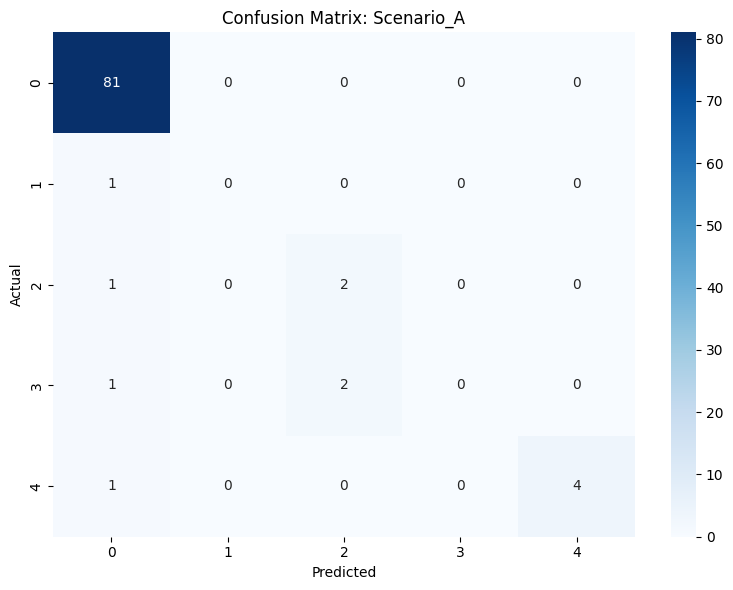

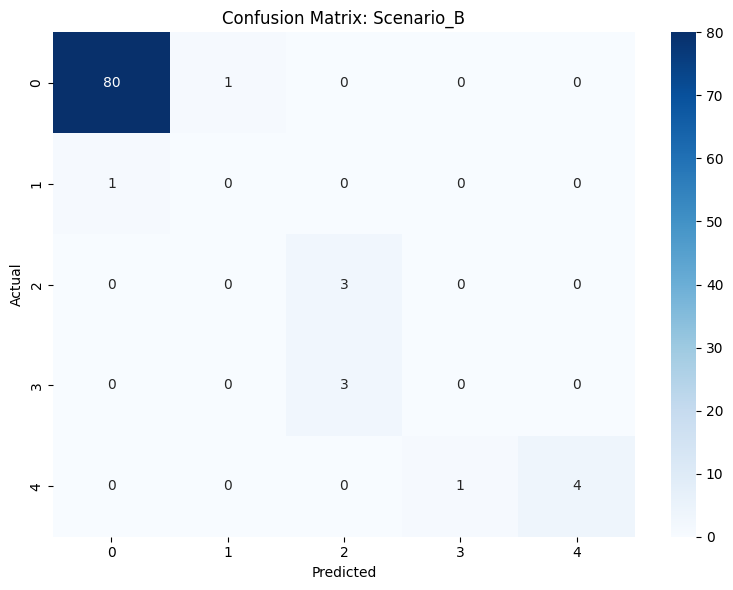

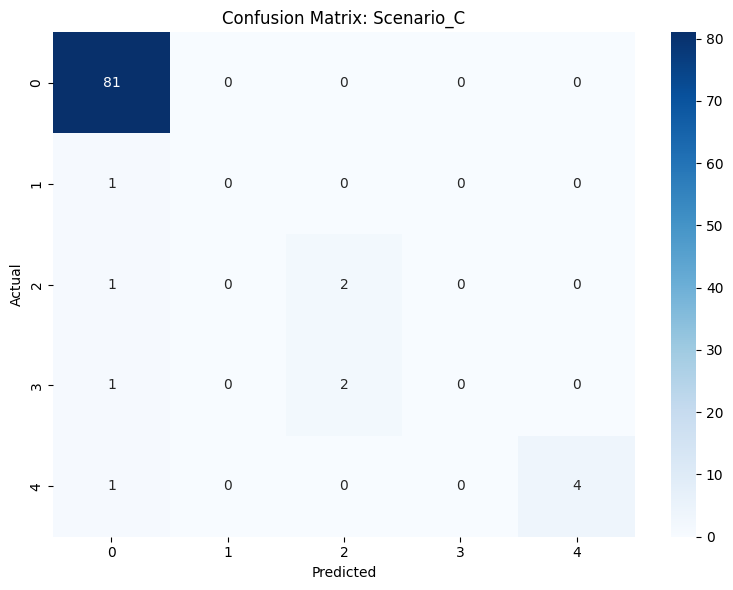

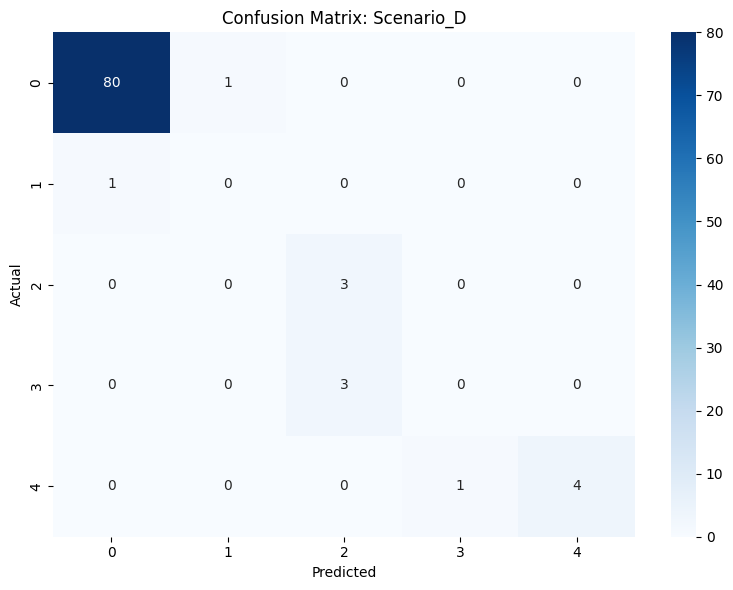


✅ Excel saved at: /content/hepatitis_RF_results.xlsx


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

results = {}  # Store metrics per scenario

# Utility function to calculate metrics & show confusion matrix inline
def evaluate_and_store(y_true, y_pred, scenario_name):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Store metrics
    results[scenario_name] = {
        "Accuracy": acc,
        "Macro Precision": prec,
        "Macro Recall": rec,
        "Macro F1": f1
    }

    # Show confusion matrix in notebook
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {scenario_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Evaluate and display each scenario
evaluate_and_store(y_test, y_test_pred_a, "Scenario_A")
evaluate_and_store(y_test, y_test_pred_b, "Scenario_B")
evaluate_and_store(y_test, y_test_pred_c, "Scenario_C")
evaluate_and_store(y_test, y_test_pred_d, "Scenario_D")

# Convert results dict to DataFrame
results_df = pd.DataFrame(results).T
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Scenario'}, inplace=True)

# Write results & detailed reports to Excel
output_path = "/content/hepatitis_RF_results.xlsx"
with pd.ExcelWriter(output_path) as writer:
    results_df.to_excel(writer, sheet_name="Summary_Metrics", index=False)
    for scenario, y_pred in zip(
        ['Scenario_A', 'Scenario_B', 'Scenario_C', 'Scenario_D'],
        [y_test_pred_a, y_test_pred_b, y_test_pred_c, y_test_pred_d]
    ):
        report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
        df_report = pd.DataFrame(report).transpose()
        df_report.to_excel(writer, sheet_name=f"{scenario}_Report")

print(f"\n✅ Excel saved at: {output_path}")


##XGBClassifier


========= XGBoost Scenario A: No ADASYN, No K-Fold =========


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Validation Report (XGB A):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        80
           1       0.00      0.00      0.00         1
           2       0.50      0.25      0.33         4
           3       1.00      0.33      0.50         3
           4       0.57      1.00      0.73         4

    accuracy                           0.93        92
   macro avg       0.61      0.52      0.51        92
weighted avg       0.93      0.93      0.92        92

Test Report (XGB A):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        81
           1       0.00      0.00      0.00         1
           2       0.60      1.00      0.75         3
           3       0.00      0.00      0.00         3
           4       1.00      0.80      0.89         5

    accuracy                           0.95        93
   macro avg       0.51      0.56      0.52        93
weighted avg       0.91   

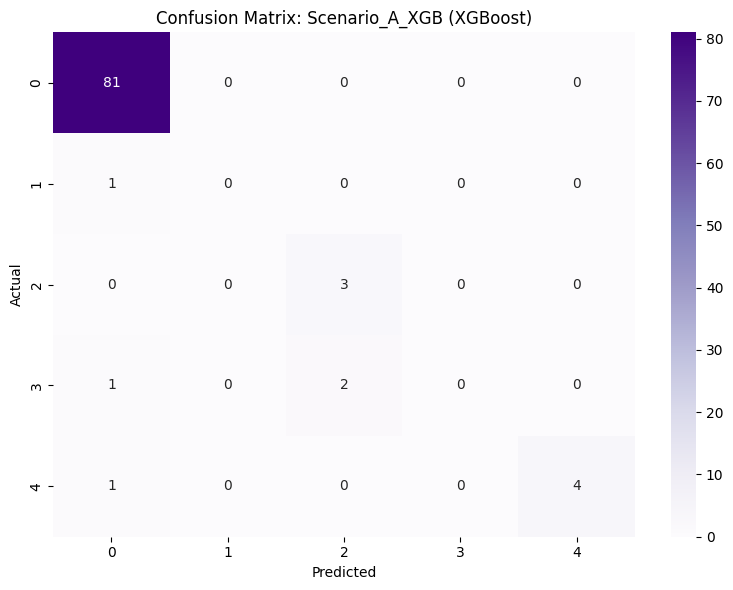


========= XGBoost Scenario B: ADASYN, No K-Fold =========


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Validation Report (XGB B):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        80
           1       1.00      1.00      1.00         1
           2       0.50      0.25      0.33         4
           3       0.67      0.67      0.67         3
           4       0.67      1.00      0.80         4

    accuracy                           0.95        92
   macro avg       0.76      0.78      0.76        92
weighted avg       0.94      0.95      0.94        92

Test Report (XGB B):
               precision    recall  f1-score   support

           0       0.99      0.98      0.98        81
           1       1.00      1.00      1.00         1
           2       0.60      1.00      0.75         3
           3       0.00      0.00      0.00         3
           4       1.00      0.80      0.89         5

    accuracy                           0.94        93
   macro avg       0.72      0.76      0.72        93
weighted avg       0.94   

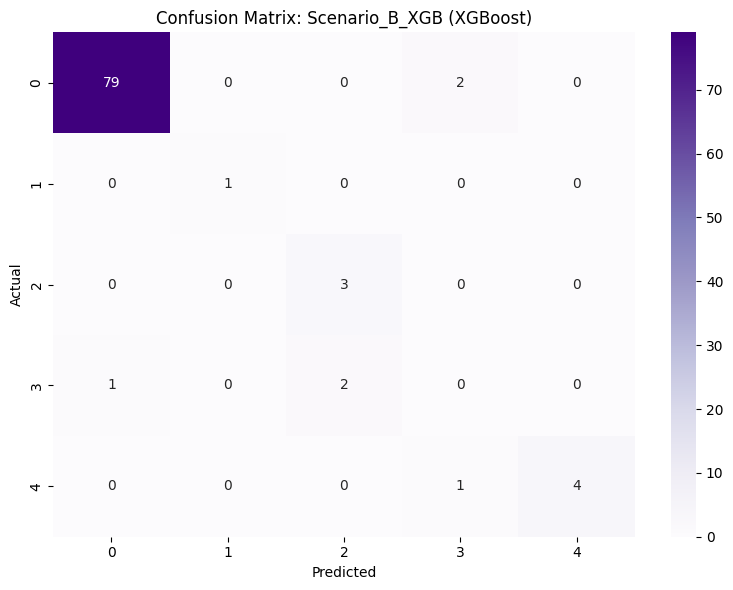


========= XGBoost Scenario C: No ADASYN, K-Fold =========

Cross-Validation Scores (XGB C): [0.88372093 0.94186047 0.94186047 0.94186047 0.89534884]
Mean CV Accuracy (XGB C): 0.9209302325581395


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Test Report (XGB C):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        81
           1       0.00      0.00      0.00         1
           2       0.60      1.00      0.75         3
           3       0.00      0.00      0.00         3
           4       1.00      0.80      0.89         5

    accuracy                           0.95        93
   macro avg       0.51      0.56      0.52        93
weighted avg       0.91      0.95      0.93        93



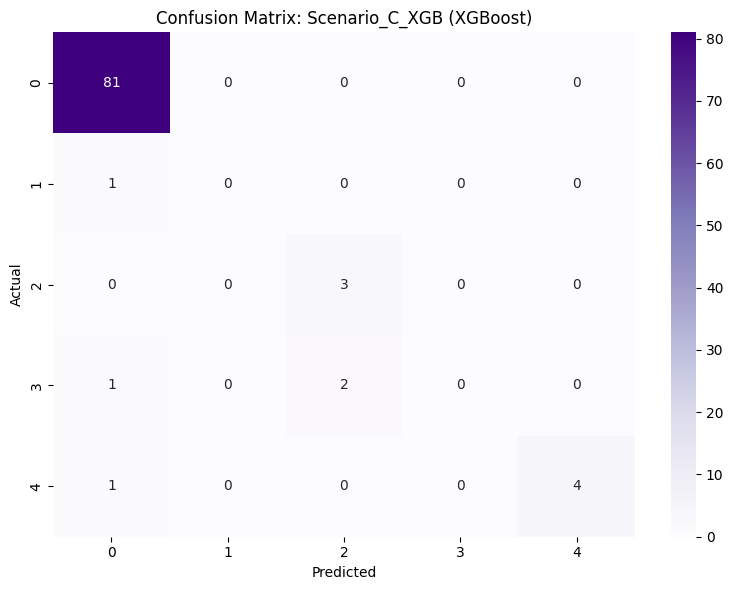


========= XGBoost Scenario D: ADASYN + K-Fold =========

Cross-Validation Scores (XGB D): [0.87209302 0.90697674 0.93023256 0.89534884 0.88372093]
Mean CV Accuracy (XGB D): 0.8976744186046511


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:02:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Test Report (XGB D):
               precision    recall  f1-score   support

           0       0.99      0.98      0.98        81
           1       1.00      1.00      1.00         1
           2       0.60      1.00      0.75         3
           3       0.00      0.00      0.00         3
           4       1.00      0.80      0.89         5

    accuracy                           0.94        93
   macro avg       0.72      0.76      0.72        93
weighted avg       0.94      0.94      0.94        93



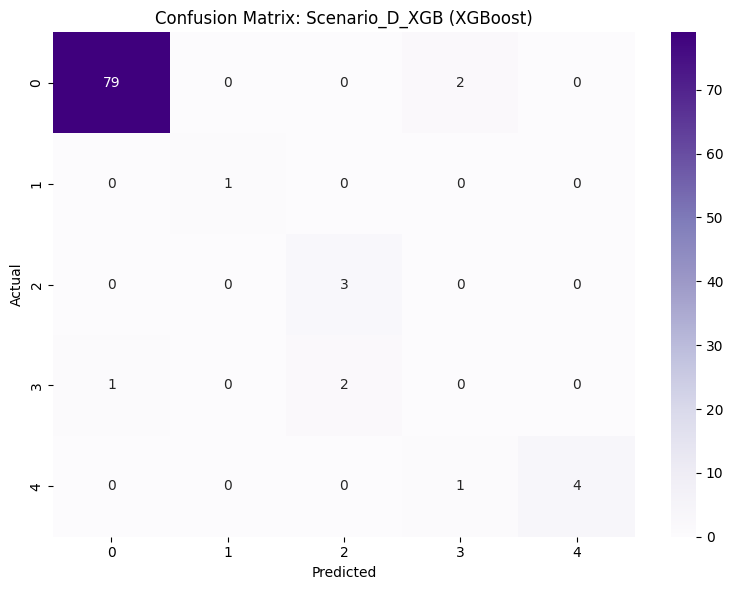


✅ XGBoost Excel saved at: /content/hepatitis_XGB_results.xlsx


In [ ]:
from xgboost import XGBClassifier

results_xgb = {}

def evaluate_and_store_xgb(y_true, y_pred, scenario_name):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    results_xgb[scenario_name] = {
        "Accuracy": acc,
        "Macro Precision": prec,
        "Macro Recall": rec,
        "Macro F1": f1
    }

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
    plt.title(f'Confusion Matrix: {scenario_name} (XGBoost)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

print("\n========= XGBoost Scenario A: No ADASYN, No K-Fold =========")
rfe_a_xgb = RFE(estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), n_features_to_select=5)
X_train_rfe_a_xgb = rfe_a_xgb.fit_transform(X_train, y_train)
X_val_rfe_a_xgb = rfe_a_xgb.transform(X_val)
X_test_rfe_a_xgb = rfe_a_xgb.transform(X_test)

xgb_a = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_a.fit(X_train_rfe_a_xgb, y_train)
y_val_pred_a_xgb = xgb_a.predict(X_val_rfe_a_xgb)
print("\nValidation Report (XGB A):\n", classification_report(y_val, y_val_pred_a_xgb, zero_division=0))
y_test_pred_a_xgb = xgb_a.predict(X_test_rfe_a_xgb)
print("Test Report (XGB A):\n", classification_report(y_test, y_test_pred_a_xgb, zero_division=0))
evaluate_and_store_xgb(y_test, y_test_pred_a_xgb, "Scenario_A_XGB")

print("\n========= XGBoost Scenario B: ADASYN, No K-Fold =========")
rfe_b_xgb = RFE(estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), n_features_to_select=5)
X_train_rfe_b_xgb = rfe_b_xgb.fit_transform(X_train, y_train)
X_val_rfe_b_xgb = rfe_b_xgb.transform(X_val)
X_test_rfe_b_xgb = rfe_b_xgb.transform(X_test)

X_train_adasyn_b_xgb, y_train_adasyn_b_xgb = ADASYN(random_state=42, n_neighbors=1).fit_resample(X_train_rfe_b_xgb, y_train)
xgb_b = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_b.fit(X_train_adasyn_b_xgb, y_train_adasyn_b_xgb)
y_val_pred_b_xgb = xgb_b.predict(X_val_rfe_b_xgb)
print("\nValidation Report (XGB B):\n", classification_report(y_val, y_val_pred_b_xgb, zero_division=0))
y_test_pred_b_xgb = xgb_b.predict(X_test_rfe_b_xgb)
print("Test Report (XGB B):\n", classification_report(y_test, y_test_pred_b_xgb, zero_division=0))
evaluate_and_store_xgb(y_test, y_test_pred_b_xgb, "Scenario_B_XGB")

print("\n========= XGBoost Scenario C: No ADASYN, K-Fold =========")
pipeline_c_xgb = Pipeline([
    ('rfe', RFE(estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), n_features_to_select=5)),
    ('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
])
scores_c_xgb = cross_val_score(
    pipeline_c_xgb, X_train, y_train,
    scoring='accuracy', cv=kf, n_jobs=-1
)
print("\nCross-Validation Scores (XGB C):", scores_c_xgb)
print("Mean CV Accuracy (XGB C):", scores_c_xgb.mean())
pipeline_c_xgb.fit(X_train, y_train)
y_test_pred_c_xgb = pipeline_c_xgb.predict(X_test)
print("Test Report (XGB C):\n", classification_report(y_test, y_test_pred_c_xgb, zero_division=0))
evaluate_and_store_xgb(y_test, y_test_pred_c_xgb, "Scenario_C_XGB")

print("\n========= XGBoost Scenario D: ADASYN + K-Fold =========")
pipeline_d_xgb = ImbPipeline([
    ('rfe', RFE(estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), n_features_to_select=5)),
    ('adasyn', ADASYN(random_state=42, n_neighbors=1)),
    ('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
])
scores_d_xgb = cross_val_score(
    pipeline_d_xgb, X_train, y_train,
    scoring='accuracy', cv=kf, n_jobs=-1
)
print("\nCross-Validation Scores (XGB D):", scores_d_xgb)
print("Mean CV Accuracy (XGB D):", scores_d_xgb.mean())
pipeline_d_xgb.fit(X_train, y_train)
y_test_pred_d_xgb = pipeline_d_xgb.predict(X_test)
print("Test Report (XGB D):\n", classification_report(y_test, y_test_pred_d_xgb, zero_division=0))
evaluate_and_store_xgb(y_test, y_test_pred_d_xgb, "Scenario_D_XGB")

# Save XGBoost results to Excel
results_df_xgb = pd.DataFrame(results_xgb).T
results_df_xgb.reset_index(inplace=True)
results_df_xgb.rename(columns={'index': 'Scenario'}, inplace=True)
output_path_xgb = "/content/hepatitis_XGB_results.xlsx"
with pd.ExcelWriter(output_path_xgb) as writer:
    results_df_xgb.to_excel(writer, sheet_name="Summary_Metrics", index=False)
    for scenario, y_pred in zip(
        ['Scenario_A_XGB', 'Scenario_B_XGB', 'Scenario_C_XGB', 'Scenario_D_XGB'],
        [y_test_pred_a_xgb, y_test_pred_b_xgb, y_test_pred_c_xgb, y_test_pred_d_xgb]
    ):
        report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
        df_report = pd.DataFrame(report).transpose()
        df_report.to_excel(writer, sheet_name=f"{scenario}_Report")

print(f"\n✅ XGBoost Excel saved at: {output_path_xgb}")


##LightGBM


========= LightGBM Scenario A: No ADASYN, No K-Fold =========
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1156
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 12
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGB

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 11
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 972
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 9
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 7
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 6
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 5
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 5
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0

Validation Report (LGBM A):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        80
           1       1.00      1.00      1.00         1
           2       0.67      0.50      0.57         4
           3       0.67      0.67      0.67         3
           4       0.80      1.00      0.89         4

    accuracy                           0.96        92
   macro avg       0.82      0.83      0.82        92
weighted avg       0.96      0.96      0.95        92

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
T

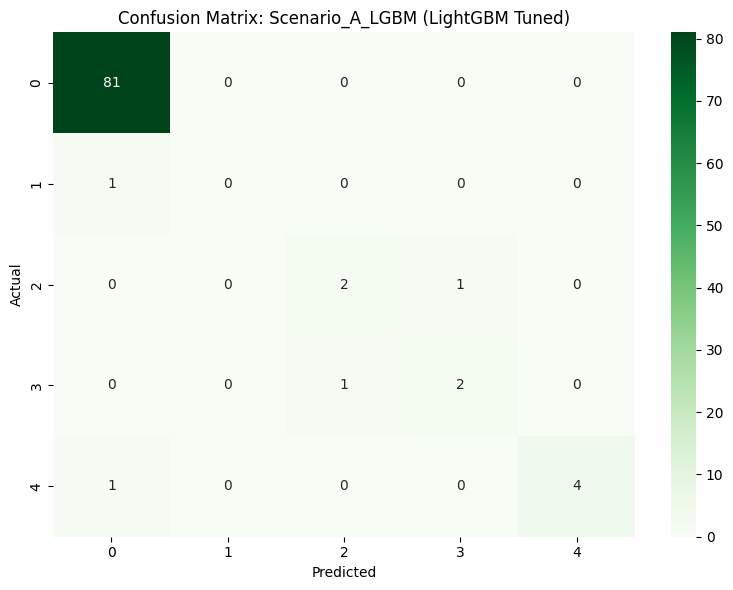


========= LightGBM Scenario B: ADASYN, No K-Fold =========
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1156
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 12
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 11
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 972
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 9
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 7
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 6
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 5
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1861, number of used features: 5
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0

Validation Report (LGBM B):
               precision    recall  f1-score   support

           0       0.99      0.97      0.98        80
           1       1.00      1.00      1.00         1
           2       0.25      0.25      0.25         4
           3       0.67      0.67      0.67         3
           4       0.60      0.75      0.67         4

    accuracy                           0.92        92
   macro avg       0.70      0.73      0.71        92
weighted avg       0.93      0.92      0.93        92

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
T

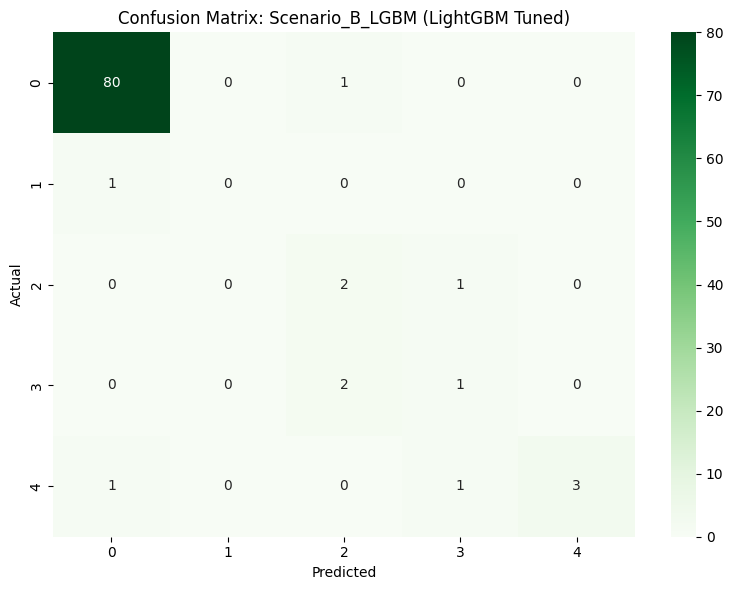


========= LightGBM Scenario C: No ADASYN, K-Fold =========

Cross-Validation Scores (LGBM C): [0.88372093 0.93023256 0.93023256 0.91860465 0.93023256]
Mean CV Accuracy (LGBM C): 0.9186046511627908
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1156
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 12
[LightGBM] [Info] Start training fr

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 11
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 10
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 972
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 9
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 7
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 6
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 5
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 5
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
Test Report (LGBM C):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        81
           1       0.00      0.00      0.00         1
           2       0.67      0.67      0.67         3
           3       0.67      0.67      0.67         3
           4       1.00      0.80      0.89         5

    accuracy                           0.96        93
   macro avg       0.66      0.63      0.64        93
weighted avg       0.95      0.96      0.95        93



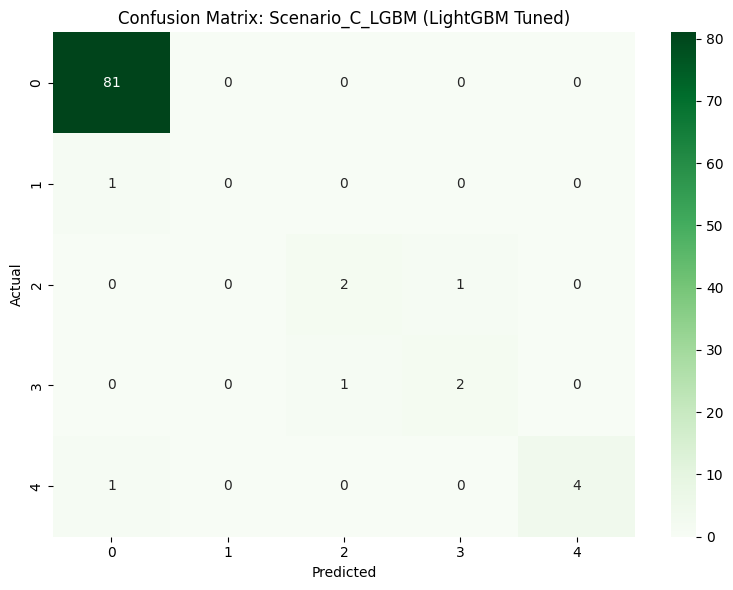


========= LightGBM Scenario D: ADASYN + K-Fold =========

Cross-Validation Scores (LGBM D): [0.8372093  0.93023256 0.91860465 0.87209302 0.95348837]
Mean CV Accuracy (LGBM D): 0.9023255813953488
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1156
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 12
[LightGBM] [Info] Start training from

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 11
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightG

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 10
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 972
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 9
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 7
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 6
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 5
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] S

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1861, number of used features: 5
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
Test Report (LGBM D):
               precision    recall  f1-score   support

           0       0.98      0.99      0.98        81
           1       0.00      0.00      0.00         1
           2       0.40      0.67      0.50         3
           3       0.33      0.33      0.33         3
           4       1.00      0.60      0.75         5

    accuracy                           0.92        93
   macro avg       0.54      0.52      0.51        93
weighted avg       0.93      0.92      0.92        93



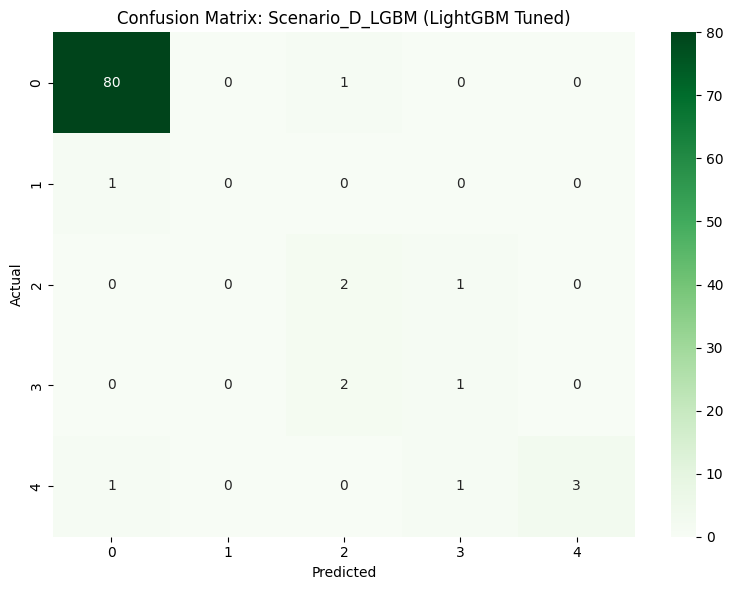


✅ LightGBM Excel saved at: /content/hepatitis_LGBM_results.xlsx


In [ ]:
from lightgbm import LGBMClassifier

# ✅ Tuned LightGBM instance
lgbm_best = LGBMClassifier(
    random_state=42,
    num_leaves=31,
    max_depth=8,
    min_data_in_leaf=1,
    min_gain_to_split=0,
    learning_rate=0.05,
    n_estimators=300,
    class_weight='balanced'
)

results_lgbm = {}

def evaluate_and_store_lgbm(y_true, y_pred, scenario_name):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    results_lgbm[scenario_name] = {
        "Accuracy": acc,
        "Macro Precision": prec,
        "Macro Recall": rec,
        "Macro F1": f1
    }

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f'Confusion Matrix: {scenario_name} (LightGBM Tuned)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

print("\n========= LightGBM Scenario A: No ADASYN, No K-Fold =========")
rfe_a_lgbm = RFE(estimator=lgbm_best, n_features_to_select=5)
X_train_rfe_a_lgbm = rfe_a_lgbm.fit_transform(X_train, y_train)
X_val_rfe_a_lgbm = rfe_a_lgbm.transform(X_val)
X_test_rfe_a_lgbm = rfe_a_lgbm.transform(X_test)

lgbm_a = lgbm_best
lgbm_a.fit(X_train_rfe_a_lgbm, y_train)
y_val_pred_a_lgbm = lgbm_a.predict(X_val_rfe_a_lgbm)
print("\nValidation Report (LGBM A):\n", classification_report(y_val, y_val_pred_a_lgbm, zero_division=0))
y_test_pred_a_lgbm = lgbm_a.predict(X_test_rfe_a_lgbm)
print("Test Report (LGBM A):\n", classification_report(y_test, y_test_pred_a_lgbm, zero_division=0))
evaluate_and_store_lgbm(y_test, y_test_pred_a_lgbm, "Scenario_A_LGBM")

print("\n========= LightGBM Scenario B: ADASYN, No K-Fold =========")
rfe_b_lgbm = RFE(estimator=lgbm_best, n_features_to_select=5)
X_train_rfe_b_lgbm = rfe_b_lgbm.fit_transform(X_train, y_train)
X_val_rfe_b_lgbm = rfe_b_lgbm.transform(X_val)
X_test_rfe_b_lgbm = rfe_b_lgbm.transform(X_test)

X_train_adasyn_b_lgbm, y_train_adasyn_b_lgbm = ADASYN(random_state=42, n_neighbors=1).fit_resample(X_train_rfe_b_lgbm, y_train)
lgbm_b = lgbm_best
lgbm_b.fit(X_train_adasyn_b_lgbm, y_train_adasyn_b_lgbm)
y_val_pred_b_lgbm = lgbm_b.predict(X_val_rfe_b_lgbm)
print("\nValidation Report (LGBM B):\n", classification_report(y_val, y_val_pred_b_lgbm, zero_division=0))
y_test_pred_b_lgbm = lgbm_b.predict(X_test_rfe_b_lgbm)
print("Test Report (LGBM B):\n", classification_report(y_test, y_test_pred_b_lgbm, zero_division=0))
evaluate_and_store_lgbm(y_test, y_test_pred_b_lgbm, "Scenario_B_LGBM")

print("\n========= LightGBM Scenario C: No ADASYN, K-Fold =========")
pipeline_c_lgbm = Pipeline([
    ('rfe', RFE(estimator=lgbm_best, n_features_to_select=5)),
    ('clf', lgbm_best)
])
scores_c_lgbm = cross_val_score(
    pipeline_c_lgbm, X_train, y_train,
    scoring='accuracy', cv=kf, n_jobs=-1
)
print("\nCross-Validation Scores (LGBM C):", scores_c_lgbm)
print("Mean CV Accuracy (LGBM C):", scores_c_lgbm.mean())
pipeline_c_lgbm.fit(X_train, y_train)
y_test_pred_c_lgbm = pipeline_c_lgbm.predict(X_test)
print("Test Report (LGBM C):\n", classification_report(y_test, y_test_pred_c_lgbm, zero_division=0))
evaluate_and_store_lgbm(y_test, y_test_pred_c_lgbm, "Scenario_C_LGBM")

print("\n========= LightGBM Scenario D: ADASYN + K-Fold =========")
pipeline_d_lgbm = ImbPipeline([
    ('rfe', RFE(estimator=lgbm_best, n_features_to_select=5)),
    ('adasyn', ADASYN(random_state=42, n_neighbors=1)),
    ('clf', lgbm_best)
])
scores_d_lgbm = cross_val_score(
    pipeline_d_lgbm, X_train, y_train,
    scoring='accuracy', cv=kf, n_jobs=-1
)
print("\nCross-Validation Scores (LGBM D):", scores_d_lgbm)
print("Mean CV Accuracy (LGBM D):", scores_d_lgbm.mean())
pipeline_d_lgbm.fit(X_train, y_train)
y_test_pred_d_lgbm = pipeline_d_lgbm.predict(X_test)
print("Test Report (LGBM D):\n", classification_report(y_test, y_test_pred_d_lgbm, zero_division=0))
evaluate_and_store_lgbm(y_test, y_test_pred_d_lgbm, "Scenario_D_LGBM")

# Save LightGBM results to Excel
results_df_lgbm = pd.DataFrame(results_lgbm).T
results_df_lgbm.reset_index(inplace=True)
results_df_lgbm.rename(columns={'index': 'Scenario'}, inplace=True)
output_path_lgbm = "/content/hepatitis_LGBM_results.xlsx"
with pd.ExcelWriter(output_path_lgbm) as writer:
    results_df_lgbm.to_excel(writer, sheet_name="Summary_Metrics", index=False)
    for scenario, y_pred in zip(
        ['Scenario_A_LGBM', 'Scenario_B_LGBM', 'Scenario_C_LGBM', 'Scenario_D_LGBM'],
        [y_test_pred_a_lgbm, y_test_pred_b_lgbm, y_test_pred_c_lgbm, y_test_pred_d_lgbm]
    ):
        report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
        df_report = pd.DataFrame(report).transpose()
        df_report.to_excel(writer, sheet_name=f"{scenario}_Report")

print(f"\n✅ LightGBM Excel saved at: {output_path_lgbm}")


###Confusion matrix LightGBM

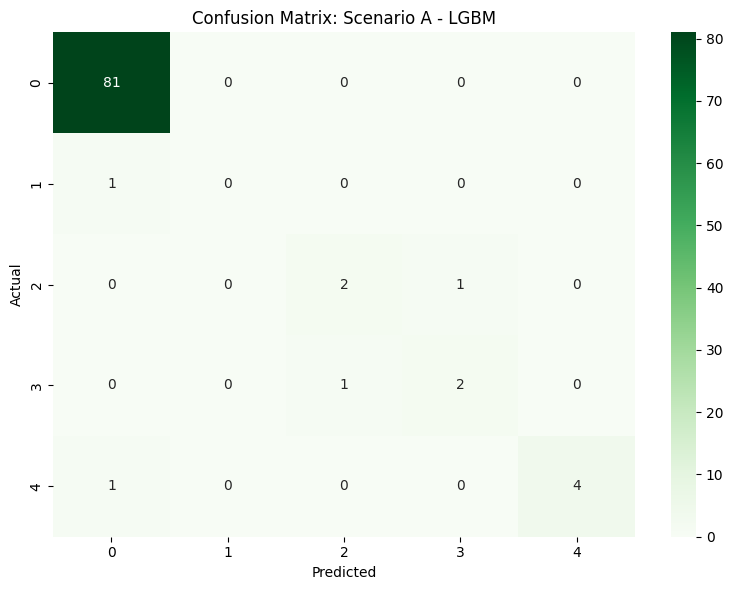

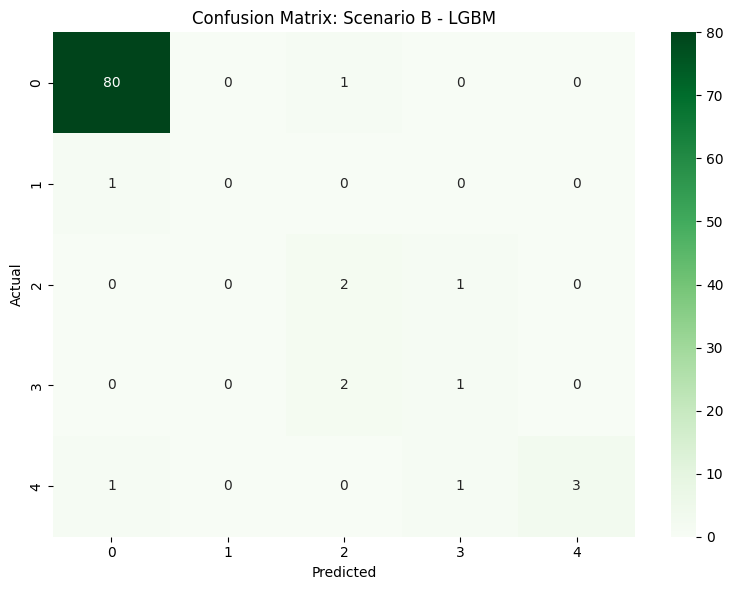

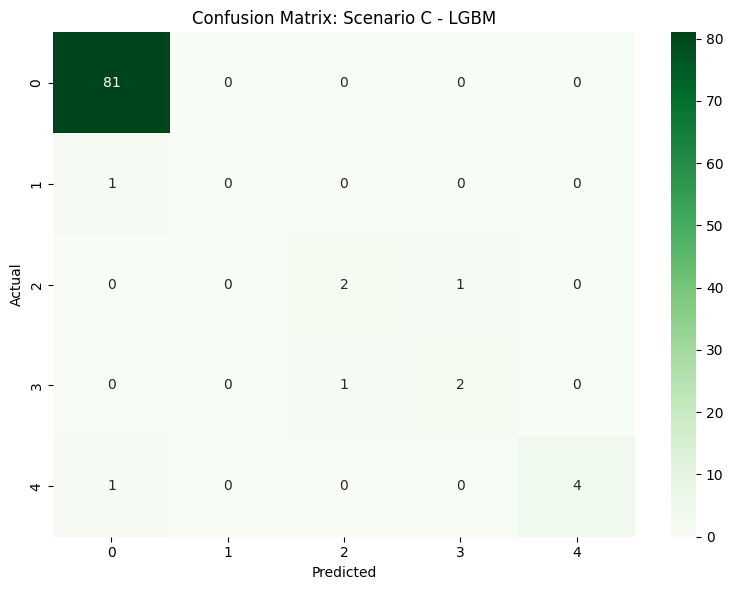

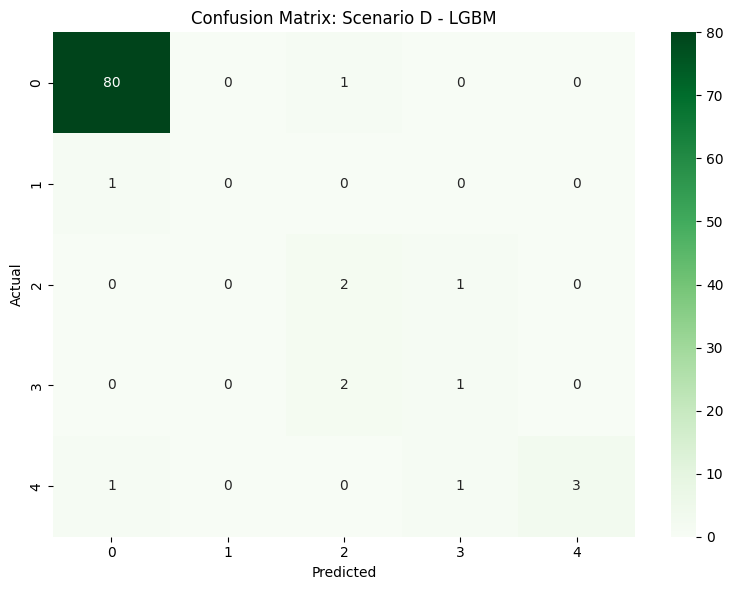

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_confusion_matrix(y_true, y_pred, scenario_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f'Confusion Matrix: {scenario_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

show_confusion_matrix(y_test, y_test_pred_a_lgbm, "Scenario A - LGBM")
show_confusion_matrix(y_test, y_test_pred_b_lgbm, "Scenario B - LGBM")
show_confusion_matrix(y_test, y_test_pred_c_lgbm, "Scenario C - LGBM")
show_confusion_matrix(y_test, y_test_pred_d_lgbm, "Scenario D - LGBM")


###MLP

###Just ensured split again

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X and y already defined from your dataset

# Split 70% train, 30% temp (which we split into 15% val, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Scale features on training data and apply to val/test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ X_train_scaled, X_val_scaled, X_test_scaled are ready!")


✅ X_train_scaled, X_val_scaled, X_test_scaled are ready!



========= MLP Scenario A: No ADASYN, No K-Fold =========


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Validation Report (MLP A):
               precision    recall  f1-score   support

           0       0.98      0.99      0.98        80
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       1.00      0.33      0.50         3
           4       0.38      0.75      0.50         4

    accuracy                           0.90        92
   macro avg       0.47      0.41      0.40        92
weighted avg       0.90      0.90      0.89        92

Test Report (MLP A):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        81
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.75      0.60      0.67         5

    accuracy                           0.90        93
   macro avg       0.34      0.32      0.33        93
weighted avg       0.88   

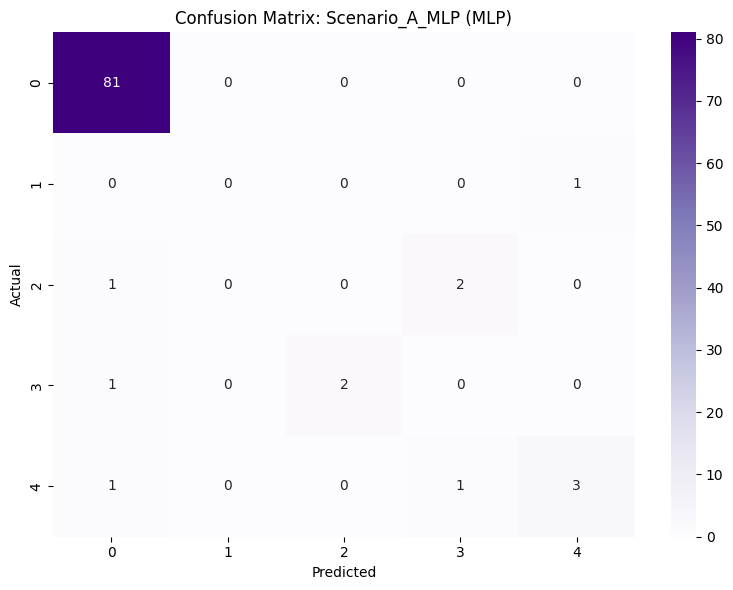


========= MLP Scenario B: ADASYN, No K-Fold =========

Validation Report (MLP B):
               precision    recall  f1-score   support

           0       0.96      0.95      0.96        80
           1       0.00      0.00      0.00         1
           2       0.17      0.25      0.20         4
           3       1.00      0.33      0.50         3
           4       0.50      0.75      0.60         4

    accuracy                           0.88        92
   macro avg       0.53      0.46      0.45        92
weighted avg       0.90      0.88      0.88        92

Test Report (MLP B):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        81
           1       1.00      1.00      1.00         1
           2       0.50      0.33      0.40         3
           3       0.00      0.00      0.00         3
           4       1.00      0.80      0.89         5

    accuracy                           0.94        93
   macro avg       0.69  

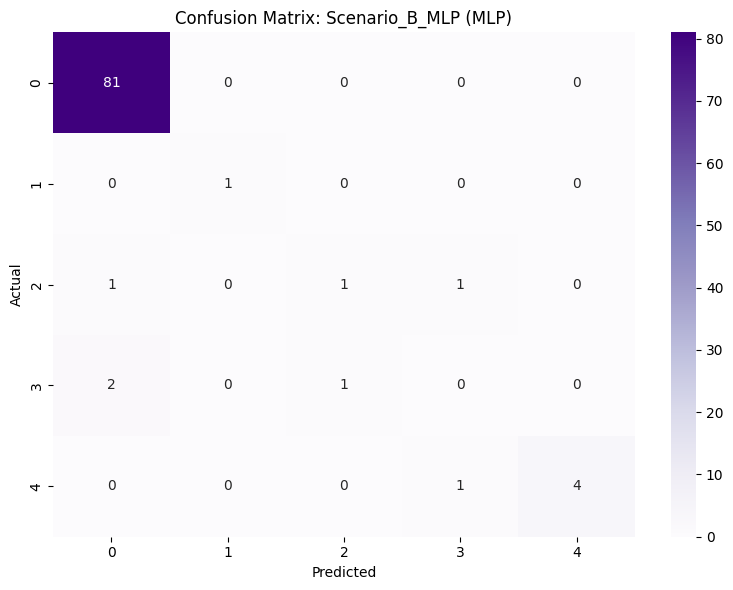


========= MLP Scenario C: No ADASYN, K-Fold =========

Cross-Validation Scores (MLP C): [0.88372093 0.89534884 0.89534884 0.87209302 0.89534884]
Mean CV Accuracy (MLP C): 0.8883720930232558


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Report (MLP C):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        81
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.75      0.60      0.67         5

    accuracy                           0.90        93
   macro avg       0.34      0.32      0.33        93
weighted avg       0.88      0.90      0.89        93



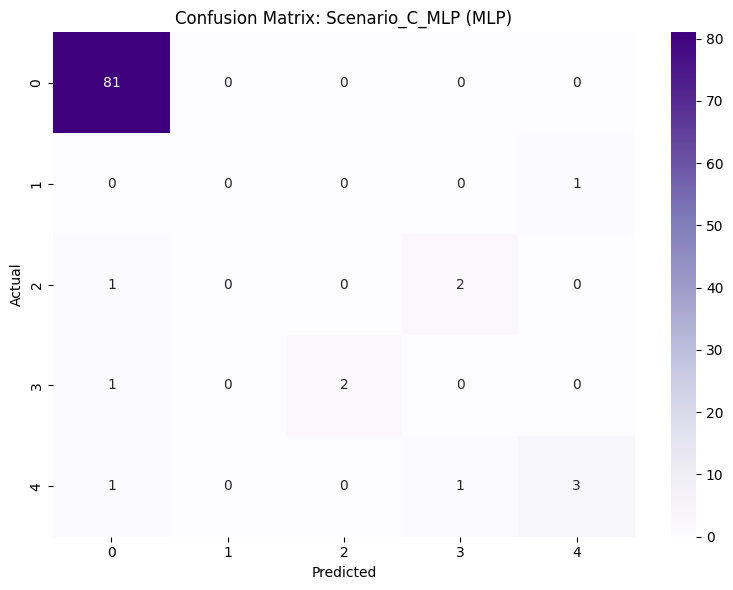


========= MLP Scenario D: ADASYN + K-Fold =========

Cross-Validation Scores (MLP D): [0.88372093 0.89534884 0.88372093 0.86046512 0.90697674]
Mean CV Accuracy (MLP D): 0.8860465116279069
Test Report (MLP D):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        81
           1       1.00      1.00      1.00         1
           2       0.50      0.33      0.40         3
           3       0.00      0.00      0.00         3
           4       1.00      0.80      0.89         5

    accuracy                           0.94        93
   macro avg       0.69      0.63      0.65        93
weighted avg       0.92      0.94      0.93        93



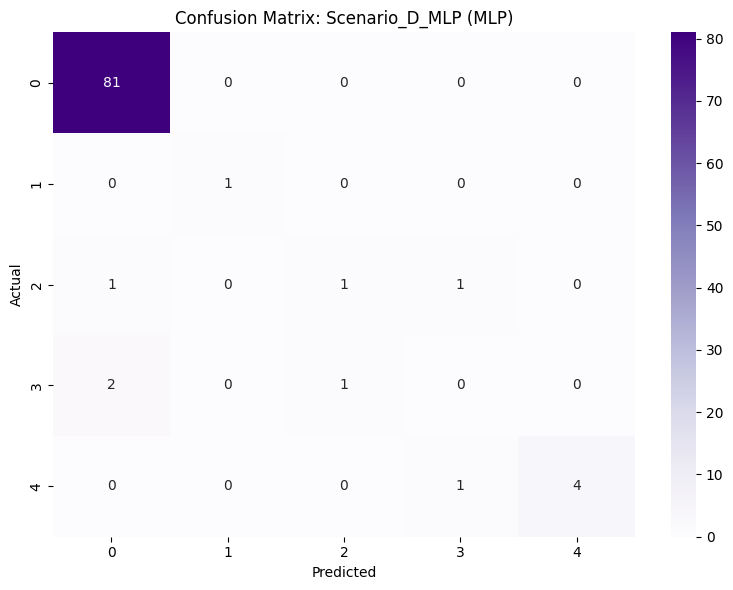


✅ MLP Excel saved at: /content/hepatitis_MLP_results.xlsx


In [ ]:

from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif

results_mlp = {}

def evaluate_and_store_mlp(y_true, y_pred, scenario_name):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    results_mlp[scenario_name] = {
        "Accuracy": acc,
        "Macro Precision": prec,
        "Macro Recall": rec,
        "Macro F1": f1
    }

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
    plt.title(f'Confusion Matrix: {scenario_name} (MLP)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

mlp_base = MLPClassifier(random_state=42, hidden_layer_sizes=(64, 32), max_iter=1000)

print("\n========= MLP Scenario A: No ADASYN, No K-Fold =========")
selector_a_mlp = SelectKBest(score_func=f_classif, k=5)
X_train_sel_a_mlp = selector_a_mlp.fit_transform(X_train_scaled, y_train)
X_val_sel_a_mlp = selector_a_mlp.transform(X_val_scaled)
X_test_sel_a_mlp = selector_a_mlp.transform(X_test_scaled)

mlp_a = mlp_base
mlp_a.fit(X_train_sel_a_mlp, y_train)
y_val_pred_a_mlp = mlp_a.predict(X_val_sel_a_mlp)
print("\nValidation Report (MLP A):\n", classification_report(y_val, y_val_pred_a_mlp, zero_division=0))
y_test_pred_a_mlp = mlp_a.predict(X_test_sel_a_mlp)
print("Test Report (MLP A):\n", classification_report(y_test, y_test_pred_a_mlp, zero_division=0))
evaluate_and_store_mlp(y_test, y_test_pred_a_mlp, "Scenario_A_MLP")

print("\n========= MLP Scenario B: ADASYN, No K-Fold =========")
selector_b_mlp = SelectKBest(score_func=f_classif, k=5)
X_train_sel_b_mlp = selector_b_mlp.fit_transform(X_train_scaled, y_train)
X_val_sel_b_mlp = selector_b_mlp.transform(X_val_scaled)
X_test_sel_b_mlp = selector_b_mlp.transform(X_test_scaled)

X_train_adasyn_b_mlp, y_train_adasyn_b_mlp = ADASYN(random_state=42, n_neighbors=1).fit_resample(X_train_sel_b_mlp, y_train)
mlp_b = mlp_base
mlp_b.fit(X_train_adasyn_b_mlp, y_train_adasyn_b_mlp)
y_val_pred_b_mlp = mlp_b.predict(X_val_sel_b_mlp)
print("\nValidation Report (MLP B):\n", classification_report(y_val, y_val_pred_b_mlp, zero_division=0))
y_test_pred_b_mlp = mlp_b.predict(X_test_sel_b_mlp)
print("Test Report (MLP B):\n", classification_report(y_test, y_test_pred_b_mlp, zero_division=0))
evaluate_and_store_mlp(y_test, y_test_pred_b_mlp, "Scenario_B_MLP")

print("\n========= MLP Scenario C: No ADASYN, K-Fold =========")
pipeline_c_mlp = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=5)),
    ('clf', mlp_base)
])
scores_c_mlp = cross_val_score(
    pipeline_c_mlp, X_train_scaled, y_train,
    scoring='accuracy', cv=kf, n_jobs=-1
)
print("\nCross-Validation Scores (MLP C):", scores_c_mlp)
print("Mean CV Accuracy (MLP C):", scores_c_mlp.mean())
pipeline_c_mlp.fit(X_train_scaled, y_train)
y_test_pred_c_mlp = pipeline_c_mlp.predict(X_test_scaled)
print("Test Report (MLP C):\n", classification_report(y_test, y_test_pred_c_mlp, zero_division=0))
evaluate_and_store_mlp(y_test, y_test_pred_c_mlp, "Scenario_C_MLP")

print("\n========= MLP Scenario D: ADASYN + K-Fold =========")
pipeline_d_mlp = ImbPipeline([
    ('select', SelectKBest(score_func=f_classif, k=5)),
    ('adasyn', ADASYN(random_state=42, n_neighbors=1)),
    ('clf', mlp_base)
])
scores_d_mlp = cross_val_score(
    pipeline_d_mlp, X_train_scaled, y_train,
    scoring='accuracy', cv=kf, n_jobs=-1
)
print("\nCross-Validation Scores (MLP D):", scores_d_mlp)
print("Mean CV Accuracy (MLP D):", scores_d_mlp.mean())
pipeline_d_mlp.fit(X_train_scaled, y_train)
y_test_pred_d_mlp = pipeline_d_mlp.predict(X_test_scaled)
print("Test Report (MLP D):\n", classification_report(y_test, y_test_pred_d_mlp, zero_division=0))
evaluate_and_store_mlp(y_test, y_test_pred_d_mlp, "Scenario_D_MLP")

# Save MLP results to Excel
results_df_mlp = pd.DataFrame(results_mlp).T
results_df_mlp.reset_index(inplace=True)
results_df_mlp.rename(columns={'index': 'Scenario'}, inplace=True)
output_path_mlp = "/content/hepatitis_MLP_results.xlsx"
with pd.ExcelWriter(output_path_mlp) as writer:
    results_df_mlp.to_excel(writer, sheet_name="Summary_Metrics", index=False)
    for scenario, y_pred in zip(
        ['Scenario_A_MLP', 'Scenario_B_MLP', 'Scenario_C_MLP', 'Scenario_D_MLP'],
        [y_test_pred_a_mlp, y_test_pred_b_mlp, y_test_pred_c_mlp, y_test_pred_d_mlp]
    ):
        report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
        df_report = pd.DataFrame(report).transpose()
        df_report.to_excel(writer, sheet_name=f"{scenario}_Report")

print(f"\n✅ MLP Excel saved at: {output_path_mlp}")


#Response



========= MLP Scenario A: No ADASYN, No K-Fold =========


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Validation Report (MLP A):
               precision    recall  f1-score   support

           0       0.98      0.99      0.98        80
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       1.00      0.33      0.50         3
           4       0.38      0.75      0.50         4

    accuracy                           0.90        92
   macro avg       0.47      0.41      0.40        92
weighted avg       0.90      0.90      0.89        92

Test Report (MLP A):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        81
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.75      0.60      0.67         5

    accuracy                           0.90        93
   macro avg       0.34      0.32      0.33        93
weighted avg       0.88   

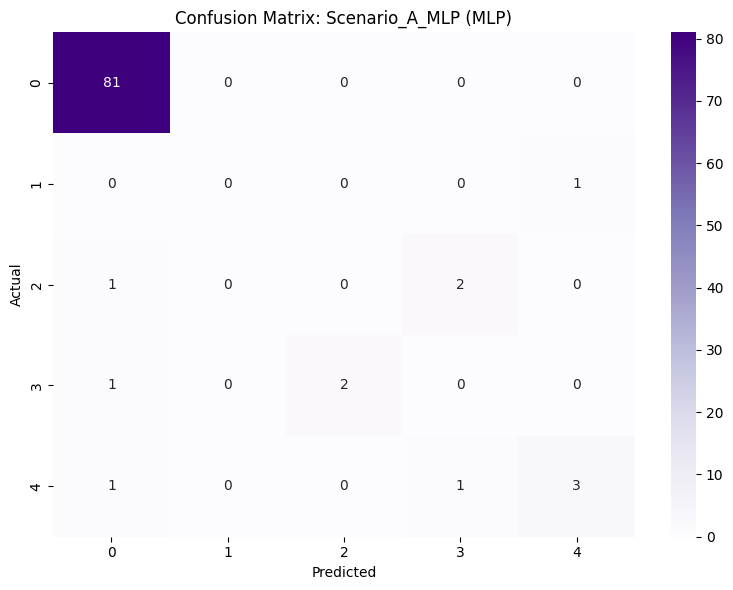


Permutation Importance (MLP Scenario A):
Feature 1 | Mean: 0.0330 | Std: 0.0180
Feature 0 | Mean: 0.0197 | Std: 0.0124
Feature 4 | Mean: 0.0161 | Std: 0.0103
Feature 2 | Mean: 0.0065 | Std: 0.0099
Feature 3 | Mean: -0.0029 | Std: 0.0107

========= MLP Scenario B: ADASYN, No K-Fold =========

Validation Report (MLP B):
               precision    recall  f1-score   support

           0       0.96      0.95      0.96        80
           1       0.00      0.00      0.00         1
           2       0.17      0.25      0.20         4
           3       1.00      0.33      0.50         3
           4       0.50      0.75      0.60         4

    accuracy                           0.88        92
   macro avg       0.53      0.46      0.45        92
weighted avg       0.90      0.88      0.88        92

Test Report (MLP B):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        81
           1       1.00      1.00      1.00         1
    

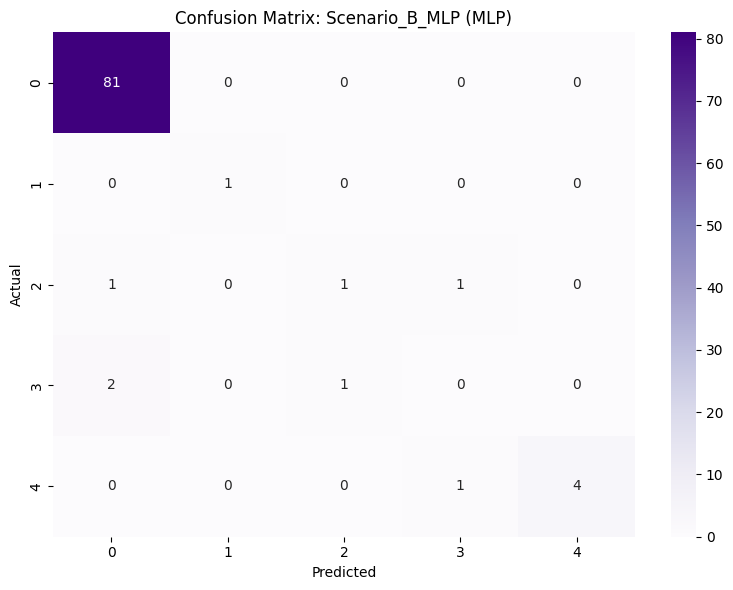


Permutation Importance (MLP Scenario B):
Feature 1 | Mean: 0.0455 | Std: 0.0223
Feature 0 | Mean: 0.0416 | Std: 0.0138
Feature 4 | Mean: 0.0398 | Std: 0.0121
Feature 2 | Mean: 0.0358 | Std: 0.0142
Feature 3 | Mean: 0.0204 | Std: 0.0145

========= MLP Scenario C: No ADASYN, K-Fold =========

Cross-Validation Scores (MLP C): [0.88372093 0.89534884 0.89534884 0.87209302 0.89534884]
Mean CV Accuracy (MLP C): 0.8883720930232558


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Report (MLP C):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        81
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.75      0.60      0.67         5

    accuracy                           0.90        93
   macro avg       0.34      0.32      0.33        93
weighted avg       0.88      0.90      0.89        93



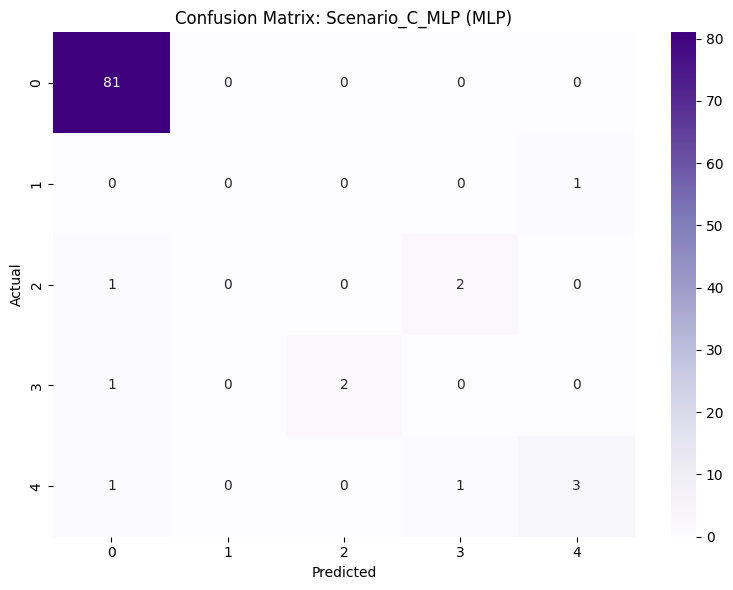


Permutation Importance (MLP Scenario C):
Feature 1 | Mean: 0.0330 | Std: 0.0180
Feature 0 | Mean: 0.0197 | Std: 0.0124
Feature 4 | Mean: 0.0161 | Std: 0.0103
Feature 2 | Mean: 0.0065 | Std: 0.0099
Feature 3 | Mean: -0.0029 | Std: 0.0107

========= MLP Scenario D: ADASYN + K-Fold =========

Cross-Validation Scores (MLP D): [0.88372093 0.89534884 0.88372093 0.86046512 0.90697674]
Mean CV Accuracy (MLP D): 0.8860465116279069
Test Report (MLP D):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        81
           1       1.00      1.00      1.00         1
           2       0.50      0.33      0.40         3
           3       0.00      0.00      0.00         3
           4       1.00      0.80      0.89         5

    accuracy                           0.94        93
   macro avg       0.69      0.63      0.65        93
weighted avg       0.92      0.94      0.93        93



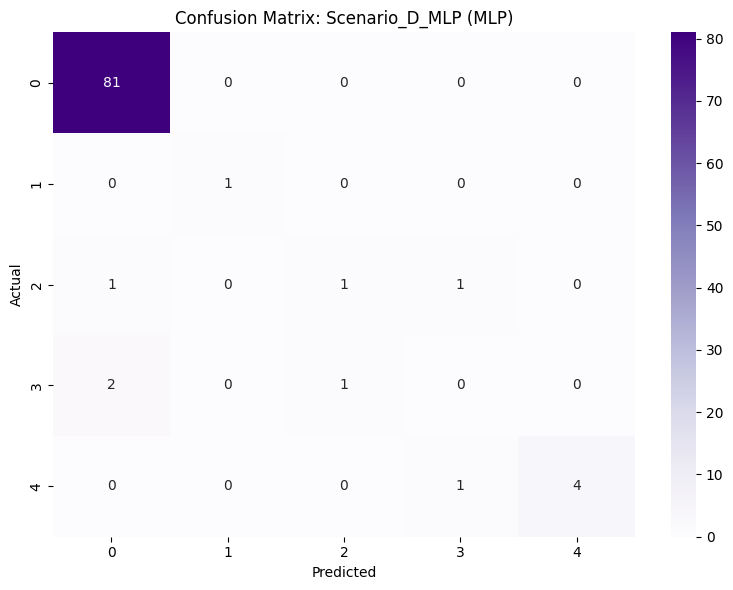


Permutation Importance (MLP Scenario D):
Feature 1 | Mean: 0.0455 | Std: 0.0223
Feature 0 | Mean: 0.0416 | Std: 0.0138
Feature 4 | Mean: 0.0398 | Std: 0.0121
Feature 2 | Mean: 0.0358 | Std: 0.0142
Feature 3 | Mean: 0.0204 | Std: 0.0145

✅ MLP Excel saved at: /content/hepatitis_MLP_results.xlsx


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns  # If you plan to use seaborn heatmaps as well

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

results_mlp = {}

def evaluate_and_store_mlp(y_true, y_pred, scenario_name):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    results_mlp[scenario_name] = {
        "Accuracy": acc,
        "Macro Precision": prec,
        "Macro Recall": rec,
        "Macro F1": f1
    }

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
    plt.title(f'Confusion Matrix: {scenario_name} (MLP)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

mlp_base = MLPClassifier(random_state=42, hidden_layer_sizes=(64, 32), max_iter=1000)

# --------- Scenario A ---------
print("\n========= MLP Scenario A: No ADASYN, No K-Fold =========")
selector_a_mlp = SelectKBest(score_func=f_classif, k=5)
X_train_sel_a_mlp = selector_a_mlp.fit_transform(X_train_scaled, y_train)
X_val_sel_a_mlp = selector_a_mlp.transform(X_val_scaled)
X_test_sel_a_mlp = selector_a_mlp.transform(X_test_scaled)

mlp_a = mlp_base
mlp_a.fit(X_train_sel_a_mlp, y_train)
y_val_pred_a_mlp = mlp_a.predict(X_val_sel_a_mlp)
print("\nValidation Report (MLP A):\n", classification_report(y_val, y_val_pred_a_mlp, zero_division=0))
y_test_pred_a_mlp = mlp_a.predict(X_test_sel_a_mlp)
print("Test Report (MLP A):\n", classification_report(y_test, y_test_pred_a_mlp, zero_division=0))
evaluate_and_store_mlp(y_test, y_test_pred_a_mlp, "Scenario_A_MLP")

perm_result_a = permutation_importance(
    mlp_a, X_test_sel_a_mlp, y_test, n_repeats=30, random_state=42, scoring='accuracy'
)
sorted_idx_a = perm_result_a.importances_mean.argsort()[::-1]
print("\nPermutation Importance (MLP Scenario A):")
for i in sorted_idx_a:
    print(f"Feature {i} | Mean: {perm_result_a.importances_mean[i]:.4f} | Std: {perm_result_a.importances_std[i]:.4f}")

# --------- Scenario B ---------
print("\n========= MLP Scenario B: ADASYN, No K-Fold =========")
selector_b_mlp = SelectKBest(score_func=f_classif, k=5)
X_train_sel_b_mlp = selector_b_mlp.fit_transform(X_train_scaled, y_train)
X_val_sel_b_mlp = selector_b_mlp.transform(X_val_scaled)
X_test_sel_b_mlp = selector_b_mlp.transform(X_test_scaled)

X_train_adasyn_b_mlp, y_train_adasyn_b_mlp = ADASYN(random_state=42, n_neighbors=1).fit_resample(X_train_sel_b_mlp, y_train)
mlp_b = mlp_base
mlp_b.fit(X_train_adasyn_b_mlp, y_train_adasyn_b_mlp)
y_val_pred_b_mlp = mlp_b.predict(X_val_sel_b_mlp)
print("\nValidation Report (MLP B):\n", classification_report(y_val, y_val_pred_b_mlp, zero_division=0))
y_test_pred_b_mlp = mlp_b.predict(X_test_sel_b_mlp)
print("Test Report (MLP B):\n", classification_report(y_test, y_test_pred_b_mlp, zero_division=0))
evaluate_and_store_mlp(y_test, y_test_pred_b_mlp, "Scenario_B_MLP")

perm_result_b = permutation_importance(
    mlp_b, X_test_sel_b_mlp, y_test, n_repeats=30, random_state=42, scoring='accuracy'
)
sorted_idx_b = perm_result_b.importances_mean.argsort()[::-1]
print("\nPermutation Importance (MLP Scenario B):")
for i in sorted_idx_b:
    print(f"Feature {i} | Mean: {perm_result_b.importances_mean[i]:.4f} | Std: {perm_result_b.importances_std[i]:.4f}")

# --------- Scenario C ---------
print("\n========= MLP Scenario C: No ADASYN, K-Fold =========")
pipeline_c_mlp = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=5)),
    ('clf', mlp_base)
])
scores_c_mlp = cross_val_score(
    pipeline_c_mlp, X_train_scaled, y_train,
    scoring='accuracy', cv=kf, n_jobs=-1
)
print("\nCross-Validation Scores (MLP C):", scores_c_mlp)
print("Mean CV Accuracy (MLP C):", scores_c_mlp.mean())
pipeline_c_mlp.fit(X_train_scaled, y_train)
X_test_sel_c_mlp = pipeline_c_mlp.named_steps['select'].transform(X_test_scaled)
y_test_pred_c_mlp = pipeline_c_mlp.predict(X_test_scaled)
print("Test Report (MLP C):\n", classification_report(y_test, y_test_pred_c_mlp, zero_division=0))
evaluate_and_store_mlp(y_test, y_test_pred_c_mlp, "Scenario_C_MLP")

perm_result_c = permutation_importance(
    pipeline_c_mlp.named_steps['clf'], X_test_sel_c_mlp, y_test, n_repeats=30, random_state=42, scoring='accuracy'
)
sorted_idx_c = perm_result_c.importances_mean.argsort()[::-1]
print("\nPermutation Importance (MLP Scenario C):")
for i in sorted_idx_c:
    print(f"Feature {i} | Mean: {perm_result_c.importances_mean[i]:.4f} | Std: {perm_result_c.importances_std[i]:.4f}")

# --------- Scenario D ---------
print("\n========= MLP Scenario D: ADASYN + K-Fold =========")
pipeline_d_mlp = ImbPipeline([
    ('select', SelectKBest(score_func=f_classif, k=5)),
    ('adasyn', ADASYN(random_state=42, n_neighbors=1)),
    ('clf', mlp_base)
])
scores_d_mlp = cross_val_score(
    pipeline_d_mlp, X_train_scaled, y_train,
    scoring='accuracy', cv=kf, n_jobs=-1
)
print("\nCross-Validation Scores (MLP D):", scores_d_mlp)
print("Mean CV Accuracy (MLP D):", scores_d_mlp.mean())
pipeline_d_mlp.fit(X_train_scaled, y_train)
X_test_sel_d_mlp = pipeline_d_mlp.named_steps['select'].transform(X_test_scaled)
y_test_pred_d_mlp = pipeline_d_mlp.predict(X_test_scaled)
print("Test Report (MLP D):\n", classification_report(y_test, y_test_pred_d_mlp, zero_division=0))
evaluate_and_store_mlp(y_test, y_test_pred_d_mlp, "Scenario_D_MLP")

#permutation importance
perm_result_d = permutation_importance(
    pipeline_d_mlp.named_steps['clf'], X_test_sel_d_mlp, y_test, n_repeats=30, random_state=42, scoring='accuracy'
)
sorted_idx_d = perm_result_d.importances_mean.argsort()[::-1]
print("\nPermutation Importance (MLP Scenario D):")
for i in sorted_idx_d:
    print(f"Feature {i} | Mean: {perm_result_d.importances_mean[i]:.4f} | Std: {perm_result_d.importances_std[i]:.4f}")

# Save MLP results to Excel
results_df_mlp = pd.DataFrame(results_mlp).T
results_df_mlp.reset_index(inplace=True)
results_df_mlp.rename(columns={'index': 'Scenario'}, inplace=True)
output_path_mlp = "/content/hepatitis_MLP_results.xlsx"
with pd.ExcelWriter(output_path_mlp) as writer:
    results_df_mlp.to_excel(writer, sheet_name="Summary_Metrics", index=False)
    for scenario, y_pred in zip(
        ['Scenario_A_MLP', 'Scenario_B_MLP', 'Scenario_C_MLP', 'Scenario_D_MLP'],
        [y_test_pred_a_mlp, y_test_pred_b_mlp, y_test_pred_c_mlp, y_test_pred_d_mlp]
    ):
        report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
        df_report = pd.DataFrame(report).transpose()
        df_report.to_excel(writer, sheet_name=f"{scenario}_Report")

print(f"\n✅ MLP Excel saved at: {output_path_mlp}")



🔵 Training Random Forest on 12 features
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        81
           1       0.00      0.00      0.00         1
           2       0.50      0.33      0.40         3
           3       0.50      0.33      0.40         3
           4       1.00      0.80      0.89         5

    accuracy                           0.94        93
   macro avg       0.59      0.49      0.53        93
weighted avg       0.92      0.94      0.92        93


🟢 Training XGBoost on 12 features
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        81
           1       0.00      0.00      0.00         1
           2       0.50      0.67      0.57         3
           3       0.00      0.00      0.00         3
           4       1.00      0.80      0.89         5

    accuracy                           0.94        93
   macro avg       0.50      0.49      0.49        93
w

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:05:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      1.00      0.99        81
           1       0.00      0.00      0.00         1
           2       0.50      0.67      0.57         3
           3       0.33      0.33      0.33         3
           4       1.00      0.80      0.89         5

    accuracy                           0.95        93
   macro avg       0.56      0.56      0.56        93
weighted avg       0.94      0.95      0.94        93


🔴 Training MLP on 12 features
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        81
           1       0.00      0.00      0.00         1
           2       1.00      0.67      0.80         3
           3       0.60      1.00      0.75         3
           4       1.00      0.80      0.89         5

    accuracy                           0.97        93
   macro avg       0.72      0.69      0.69        93
weighted avg       0.97      0.97      0.96   

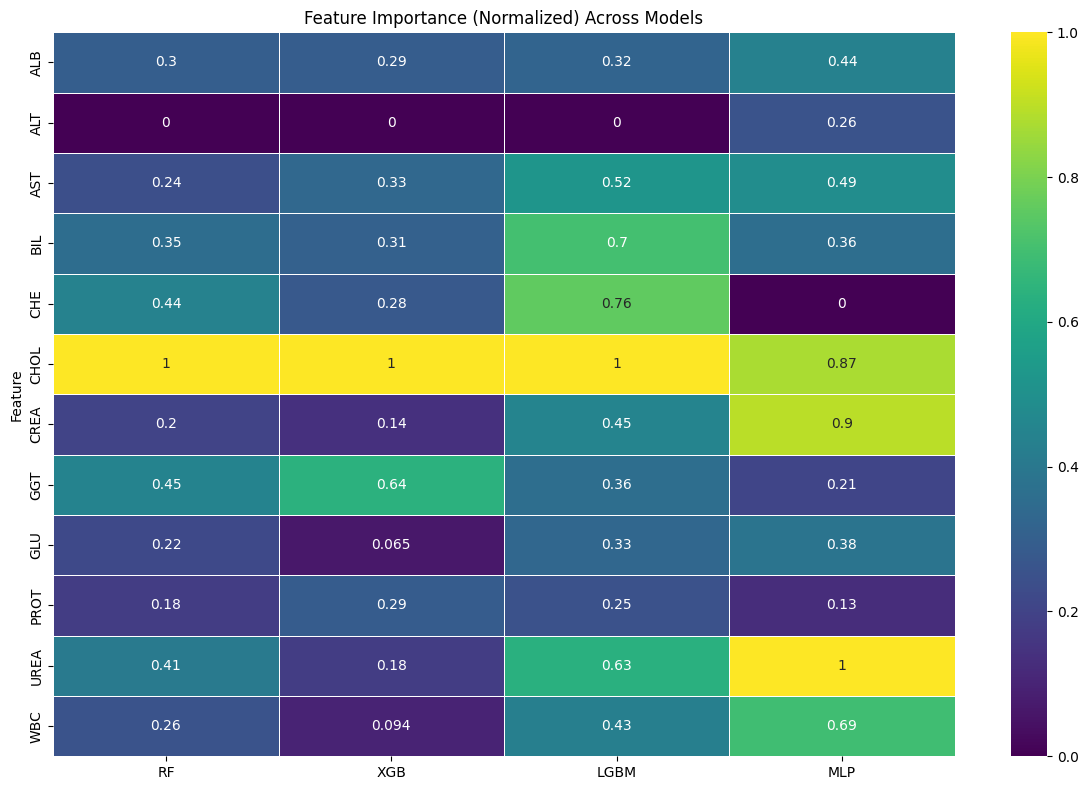


✅ Feature importance table + detailed reports saved at: /content/hepatitis_feature_importance_all12.xlsx


Feature        RF       XGB      LGBM       MLP
0      ALB  0.296021  0.290827  0.319797  0.435897
1      ALT  0.000000  0.000000  0.000000  0.256410
2      AST  0.238397  0.332396  0.521392  0.487179
3      BIL  0.353844  0.307523  0.699782  0.358974
4      CHE  0.442277  0.275635  0.755620  0.000000
5     CHOL  1.000000  1.000000  1.000000  0.871795
6     CREA  0.200968  0.136898  0.452502  0.897436
7      GGT  0.445559  0.638363  0.358956  0.205128
8      GLU  0.221301  0.064799  0.329224  0.384615
9     PROT  0.178435  0.285779  0.253807  0.128205
10    UREA  0.407296  0.177552  0.633067  1.000000
11     WBC  0.256036  0.093871  0.427846  0.692308

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

# 🔹 Replace with your real feature names (12 features)
feature_names = ["ALB", "ALT", "AST", "BIL", "CHE", "CHOL", "CREA", "GGT", "GLU", "PROT", "UREA", "WBC"]

scaler = MinMaxScaler()

# 📦 Initialize result table
results_df = pd.DataFrame({'Feature': feature_names})

# ========== RANDOM FOREST ==========
print("\n🔵 Training Random Forest on 12 features")
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train_scaled, y_train)
y_test_pred_rf = rf.predict(X_test_scaled)
print(classification_report(y_test, y_test_pred_rf, zero_division=0))

imp_rf = rf.feature_importances_
norm_rf = scaler.fit_transform(imp_rf.reshape(-1,1)).flatten()
results_df['RF'] = norm_rf

# ========== XGBOOST ==========
print("\n🟢 Training XGBoost on 12 features")
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train_scaled, y_train)
y_test_pred_xgb = xgb.predict(X_test_scaled)
print(classification_report(y_test, y_test_pred_xgb, zero_division=0))

imp_xgb = xgb.feature_importances_
norm_xgb = scaler.fit_transform(imp_xgb.reshape(-1,1)).flatten()
results_df['XGB'] = norm_xgb

# ========== LIGHTGBM ==========
print("\n🟡 Training LightGBM on 12 features")
lgb = LGBMClassifier(random_state=42)
lgb.fit(X_train_scaled, y_train)
y_test_pred_lgb = lgb.predict(X_test_scaled)
print(classification_report(y_test, y_test_pred_lgb, zero_division=0))

imp_lgb = lgb.feature_importances_
norm_lgb = scaler.fit_transform(imp_lgb.reshape(-1,1)).flatten()
results_df['LGBM'] = norm_lgb

# ========== MLP (Permutation Importance) ==========
print("\n🔴 Training MLP on 12 features")
mlp = MLPClassifier(random_state=42, hidden_layer_sizes=(64, 32), max_iter=1000)
mlp.fit(X_train_scaled, y_train)
y_test_pred_mlp = mlp.predict(X_test_scaled)
print(classification_report(y_test, y_test_pred_mlp, zero_division=0))

perm_mlp = permutation_importance(
    mlp, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='accuracy'
)
imp_mlp = perm_mlp.importances_mean
norm_mlp = scaler.fit_transform(imp_mlp.reshape(-1,1)).flatten()
results_df['MLP'] = norm_mlp

# 📊 Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(results_df.set_index('Feature'), annot=True, cmap='viridis', linewidths=0.5)
plt.title("Feature Importance (Normalized) Across Models")
plt.tight_layout()
plt.show()

# 📥 Save results
output_path = "/content/hepatitis_feature_importance_all12.xlsx"
with pd.ExcelWriter(output_path) as writer:
    results_df.to_excel(writer, sheet_name="Feature_Importance", index=False)
    for model_name, y_pred in zip(
        ["RF", "XGB", "LGBM", "MLP"],
        [y_test_pred_rf, y_test_pred_xgb, y_test_pred_lgb, y_test_pred_mlp]
    ):
        report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
        pd.DataFrame(report).transpose().to_excel(writer, sheet_name=f"{model_name}_Report")

print(f"\n✅ Feature importance table + detailed reports saved at: {output_path}")
results_df



🔹 Generating ROC-AUC for Random Forest...

🔹 Generating ROC-AUC for XGBoost...

🔹 Generating ROC-AUC for LightGBM...

🔹 Generating ROC-AUC for MLP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


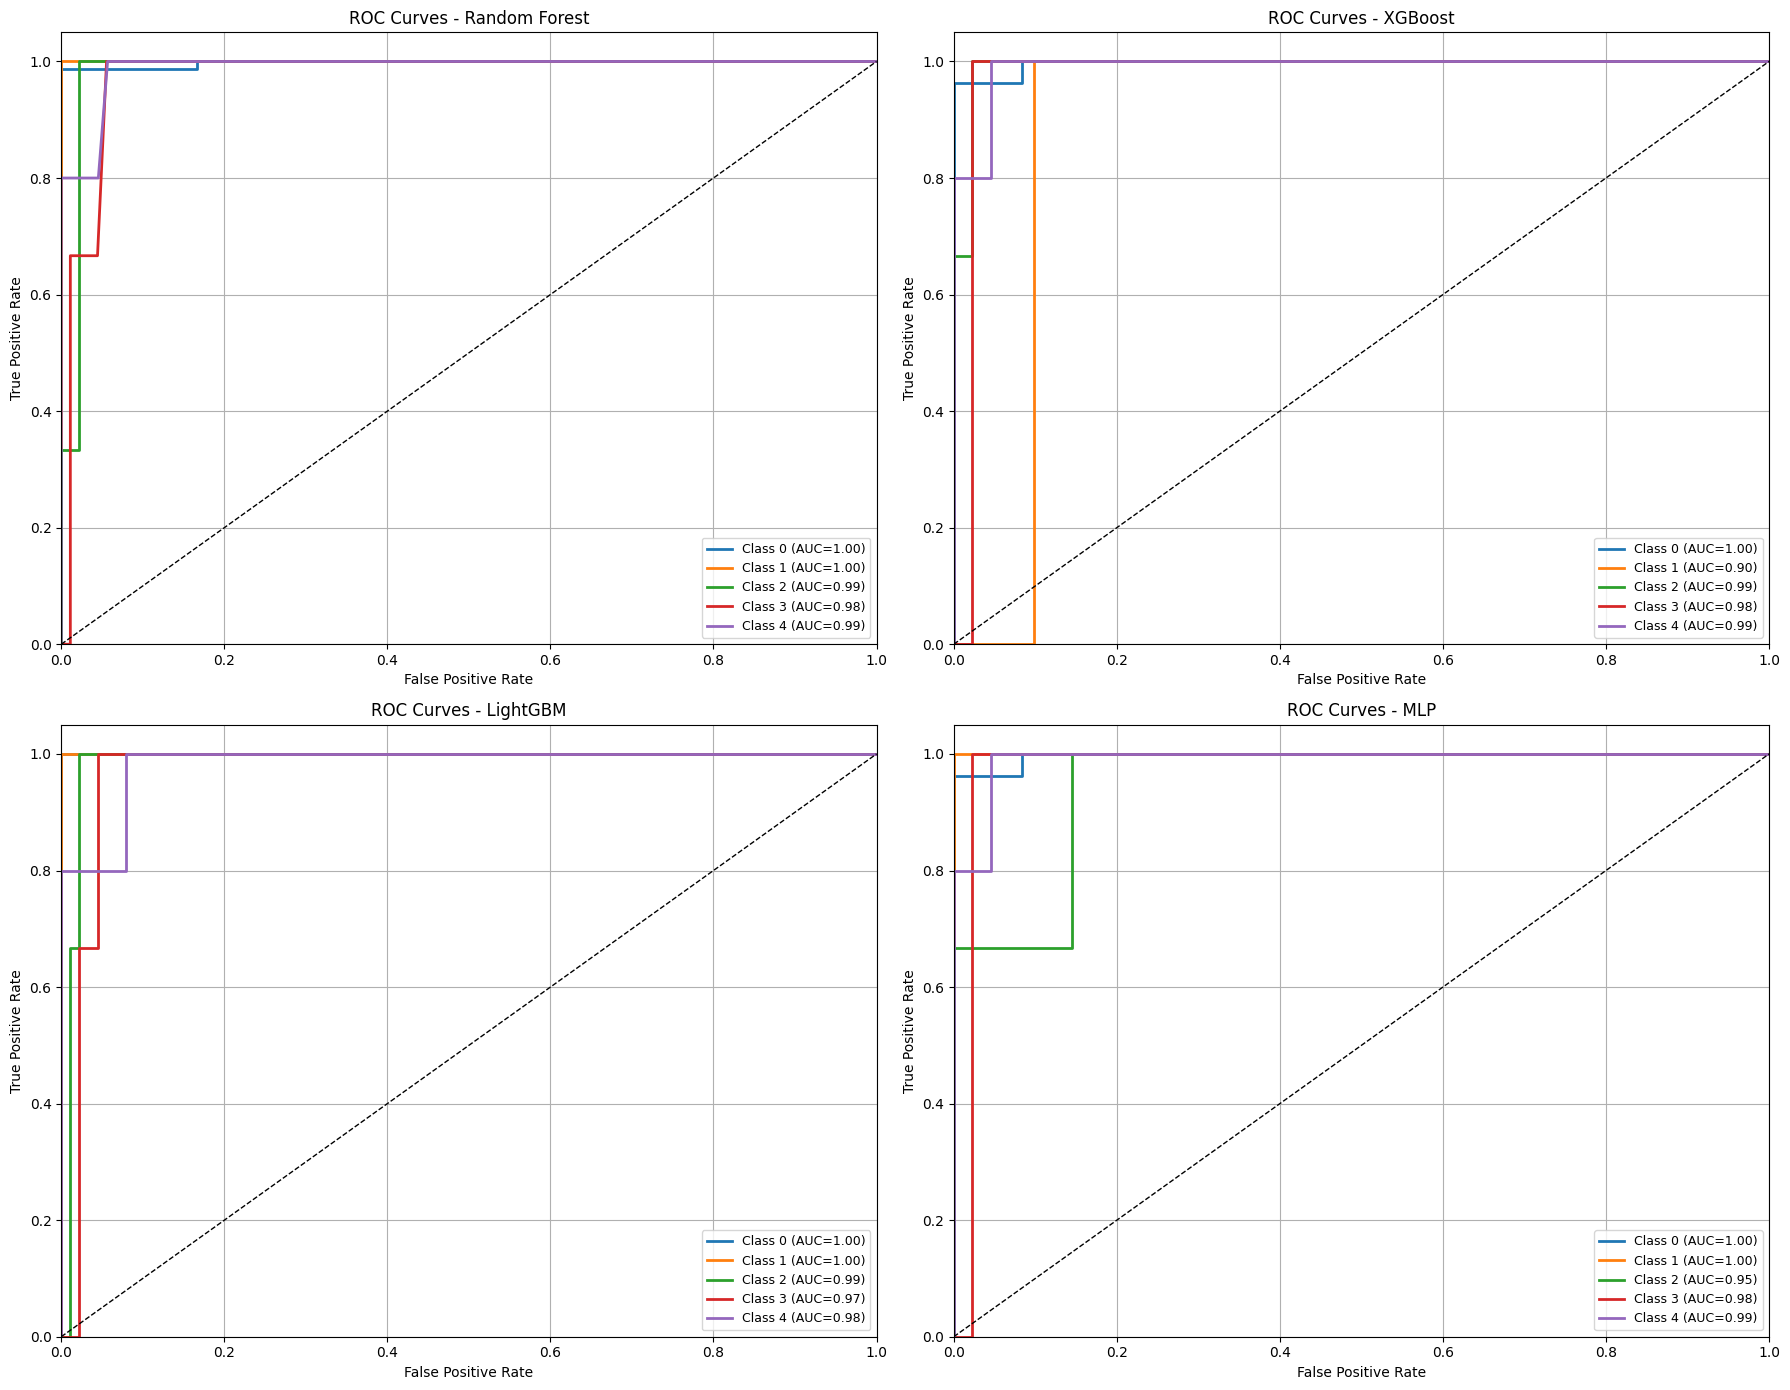

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ⚙️ Classes in your dataset (assuming 0-4 for 5-class problem)
classes = np.unique(y_train)
n_classes = len(classes)

# 🔹 Binarize y_test for multiclass ROC
y_test_bin = label_binarize(y_test, classes=classes)

# 📦 Create dict of trained models
models = {
    "Random Forest": rf,
    "XGBoost": xgb,
    "LightGBM": lgb,
    "MLP": mlp
}

# 🎨 Plot ROC for each model
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for ax, (model_name, model) in zip(axes, models.items()):
    print(f"\n🔹 Generating ROC-AUC for {model_name}...")

    # 🚨 Probabilities needed for ROC
    try:
        y_score = model.predict_proba(X_test_scaled)
    except AttributeError as e:
        print(f"[ERROR] {model_name} does not support predict_proba: {e}")
        continue

    colors = cycle(plt.cm.tab10.colors)  # 10 distinct colors

    for idx, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y_test_bin[:, idx], y_score[:, idx])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=color, lw=2, label=f"Class {classes[idx]} (AUC={roc_auc:.2f})")

    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curves - {model_name}")
    ax.legend(loc="lower right", fontsize=9)
    ax.grid(True)

plt.tight_layout()
plt.show()



🔹 Generating ROC-AUC for Random Forest...

🔹 Generating ROC-AUC for XGBoost...

🔹 Generating ROC-AUC for LightGBM...

🔹 Generating ROC-AUC for MLP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


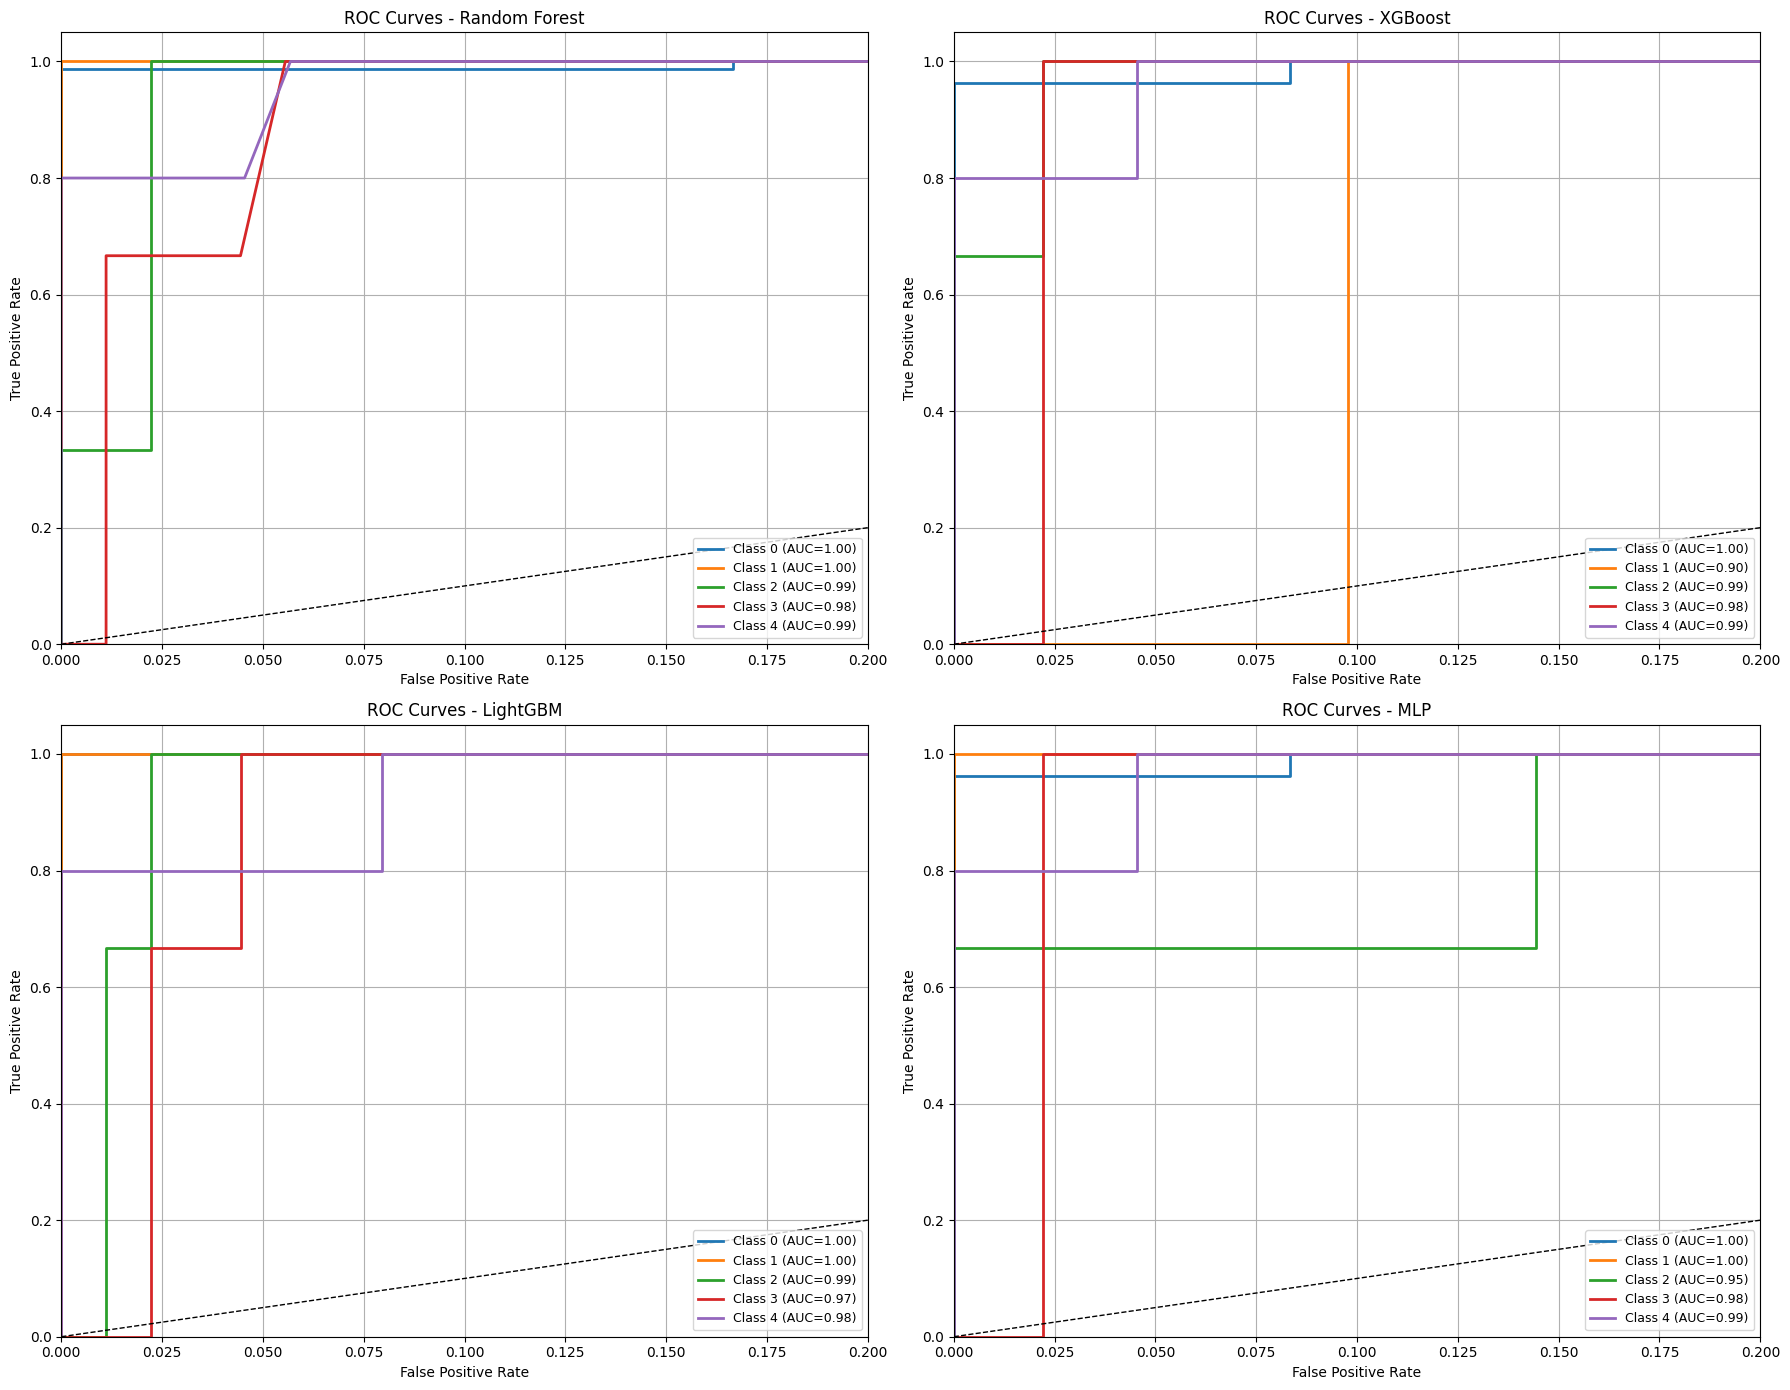

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# 🔹 Assuming you have these trained models from your previous code:
models = {
    "Random Forest": rf,
    "XGBoost": xgb,
    "LightGBM": lgb,
    "MLP": mlp
}

classes = [0, 1, 2, 3, 4]

# 🔹 Binarize the multiclass labels
y_test_bin = label_binarize(y_test, classes=classes)

# 🔹 Prepare subplots: 2×2 grid for 4 models
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.ravel()

for ax, (model_name, model) in zip(axes, models.items()):
    print(f"\n🔹 Generating ROC-AUC for {model_name}...")
    y_score = model.predict_proba(X_test_scaled)

    for idx, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, idx], y_score[:, idx])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'Class {cls} (AUC={roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_xlim([0.0, 0.2])   # 🔥 Zoom: FPR 0-0.2
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curves - {model_name}")
    ax.legend(loc="lower right", fontsize=9)
    ax.grid(True)

plt.tight_layout()
plt.show()


[ERROR] RF Scenario A: can't compute probabilities: X has 12 features, but RandomForestClassifier is expecting 5 features as input.
[ERROR] RF Scenario B: can't compute probabilities: X has 12 features, but RandomForestClassifier is expecting 5 features as input.
[ERROR] XGB Scenario A: can't compute probabilities: Feature shape mismatch, expected: 5, got 12
[ERROR] XGB Scenario B: can't compute probabilities: Feature shape mismatch, expected: 5, got 12
[ERROR] LGBM Scenario A: can't compute probabilities: Number of features of the model must match the input. Model n_features_ is 5 and input n_features is 12
[ERROR] LGBM Scenario B: can't compute probabilities: Number of features of the model must match the input. Model n_features_ is 5 and input n_features is 12
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 

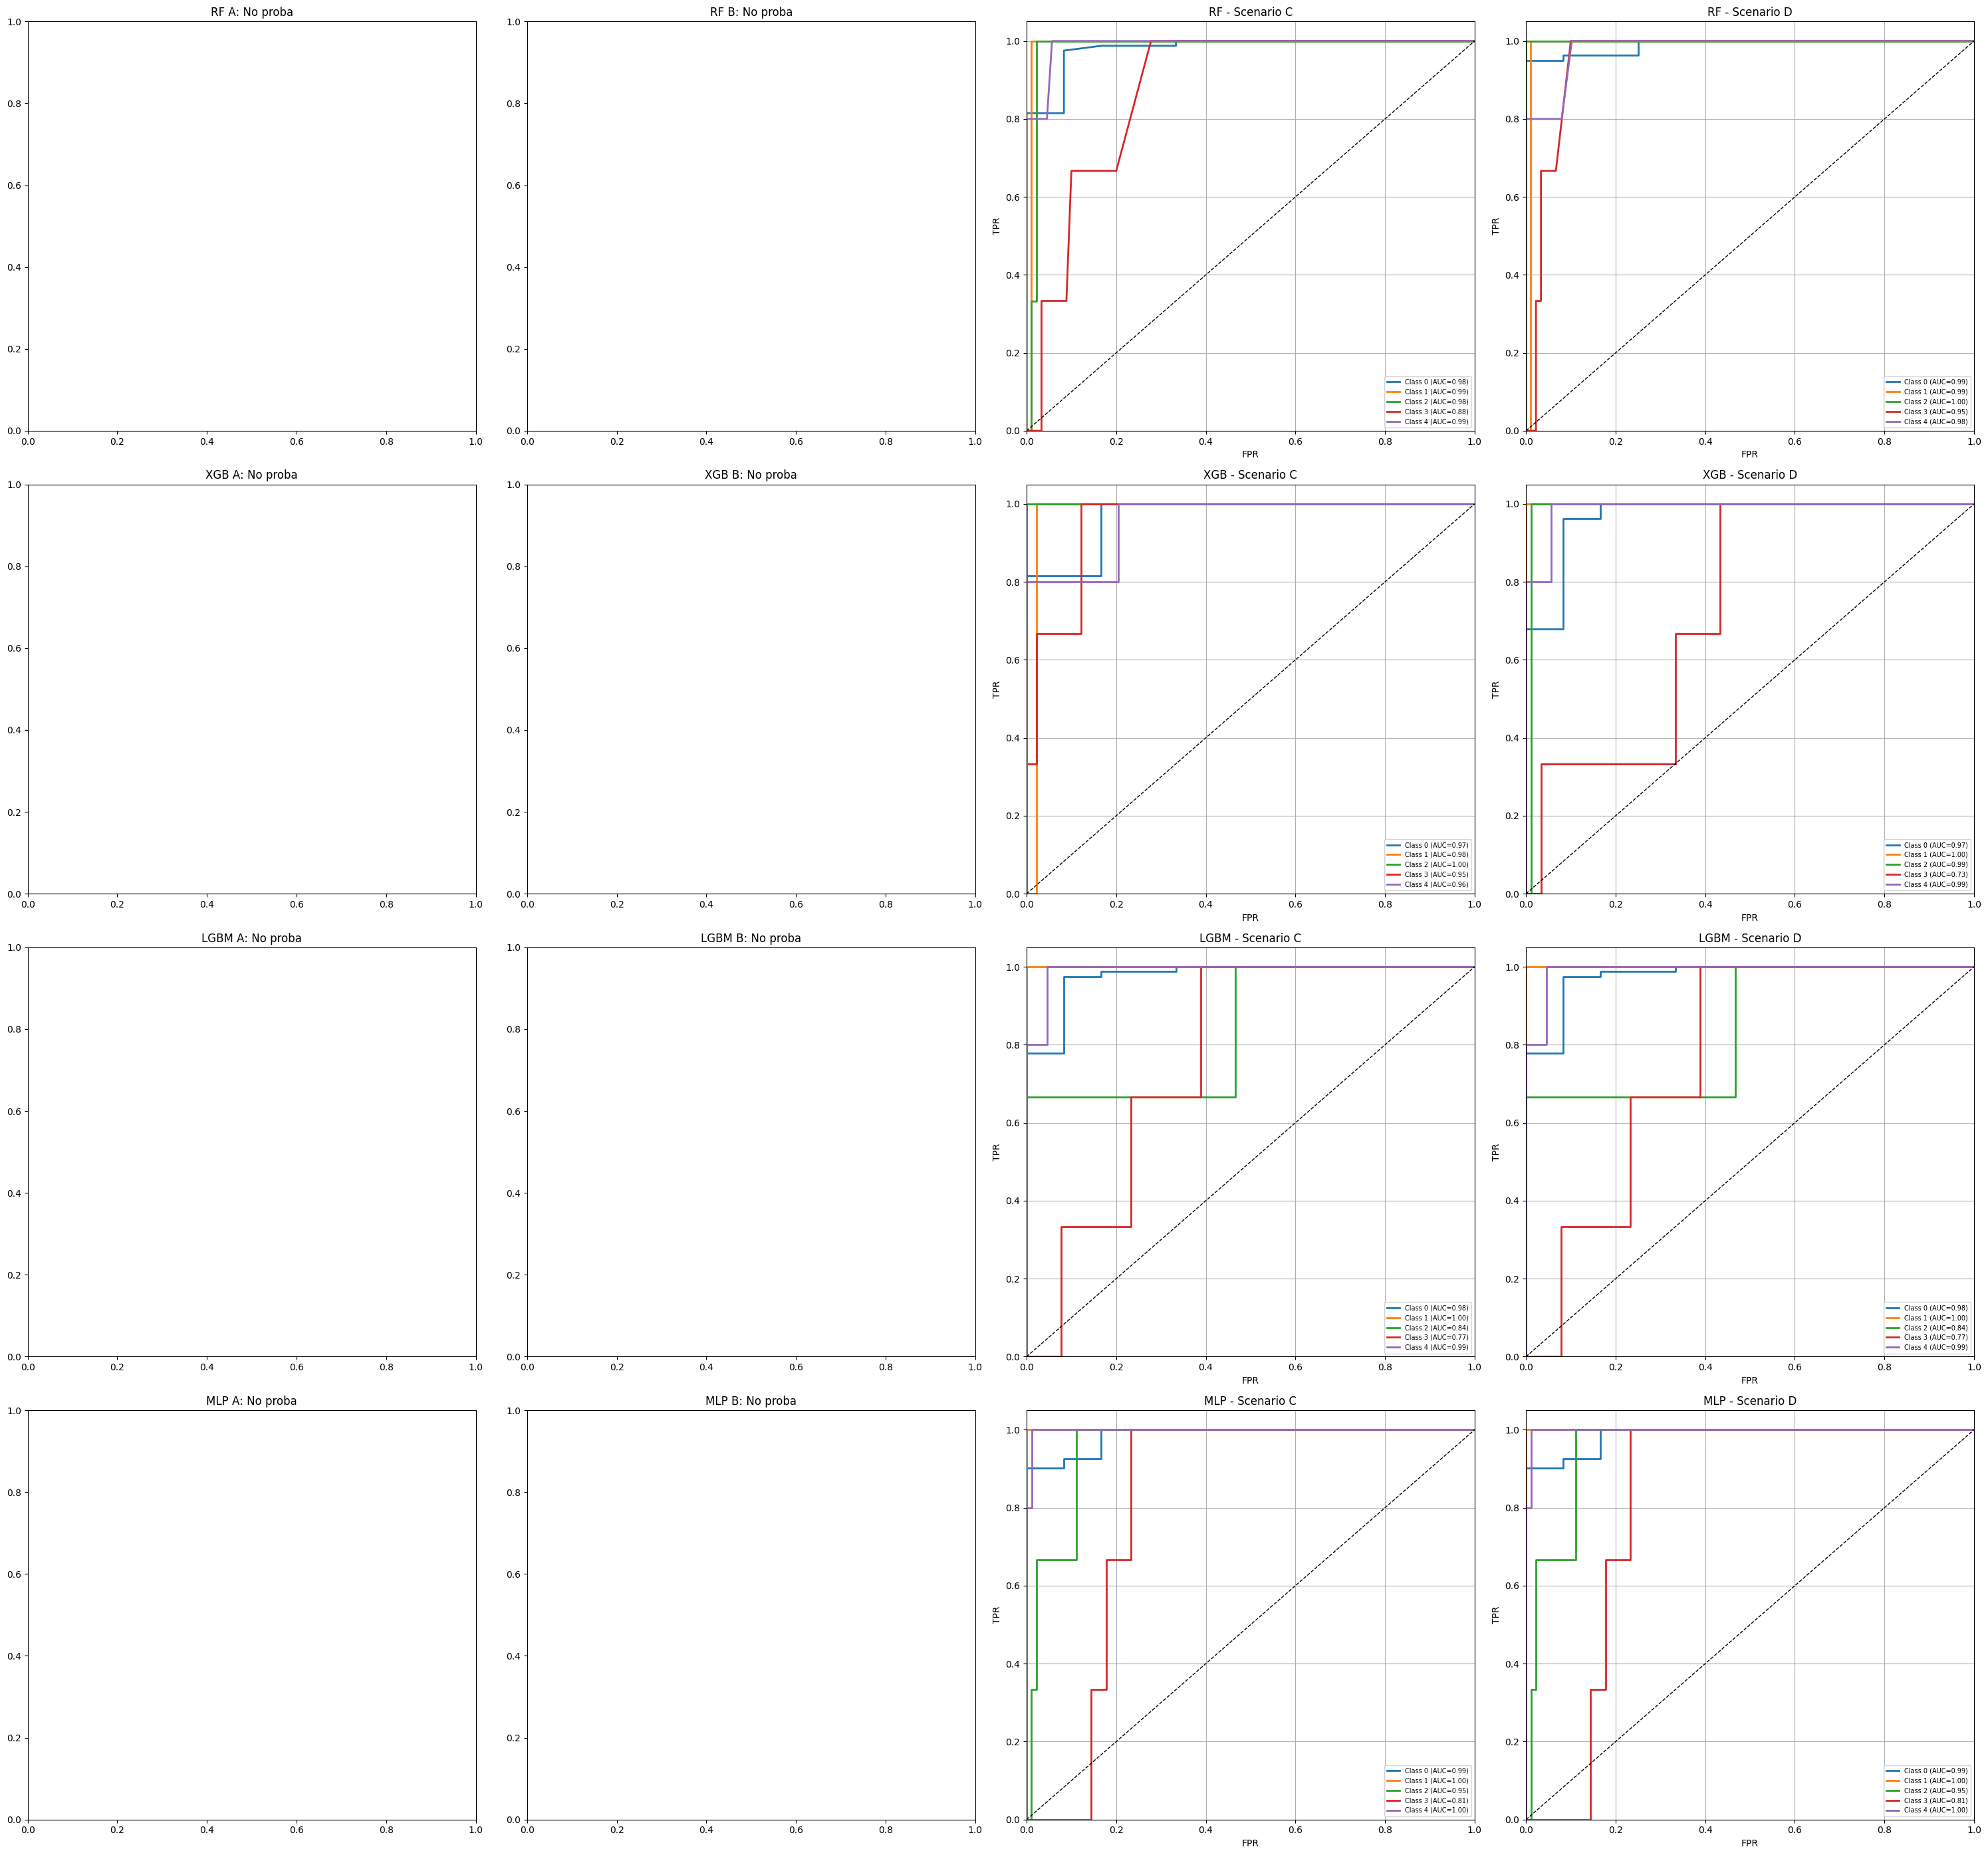

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Define your scenarios and models (match your code naming)
scenarios = ['A', 'B', 'C', 'D']
models = {
    'RF': {'A': rf_a, 'B': rf_b, 'C': pipeline_c, 'D': pipeline_d},
    'XGB': {'A': xgb_a, 'B': xgb_b, 'C': pipeline_c_xgb, 'D': pipeline_d_xgb},
    'LGBM': {'A': lgbm_a, 'B': lgbm_b, 'C': pipeline_c_lgbm, 'D': pipeline_d_lgbm},
    'MLP': {'A': mlp_a, 'B': mlp_b, 'C': pipeline_c_mlp, 'D': pipeline_d_mlp},
}

classes = np.array([0, 1, 2, 3, 4])
n_classes = len(classes)

# Binarize the true y_test labels once
y_test_bin = label_binarize(y_test, classes=classes)

fig, axs = plt.subplots(4, 4, figsize=(30, 28))  # 4x4 grid for 16 plots

for row_idx, (model_name, scenario_dict) in enumerate(models.items()):
    for col_idx, scenario in enumerate(scenarios):
        ax = axs[row_idx, col_idx]
        model = scenario_dict[scenario]

        # Predict probabilities on X_test_scaled (already scaled/test split in your script)
        try:
            y_score = model.predict_proba(X_test_scaled)
        except Exception as e:
            print(f"[ERROR] {model_name} Scenario {scenario}: can't compute probabilities: {e}")
            ax.set_title(f"{model_name} {scenario}: No proba")
            continue

        # Plot ROC curve for each class
        for idx in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, idx], y_score[:, idx])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, lw=2, label=f'Class {classes[idx]} (AUC={roc_auc:.2f})')

        ax.plot([0, 1], [0, 1], 'k--', lw=1)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title(f"{model_name} - Scenario {scenario}")
        ax.legend(loc="lower right", fontsize=7)
        ax.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0


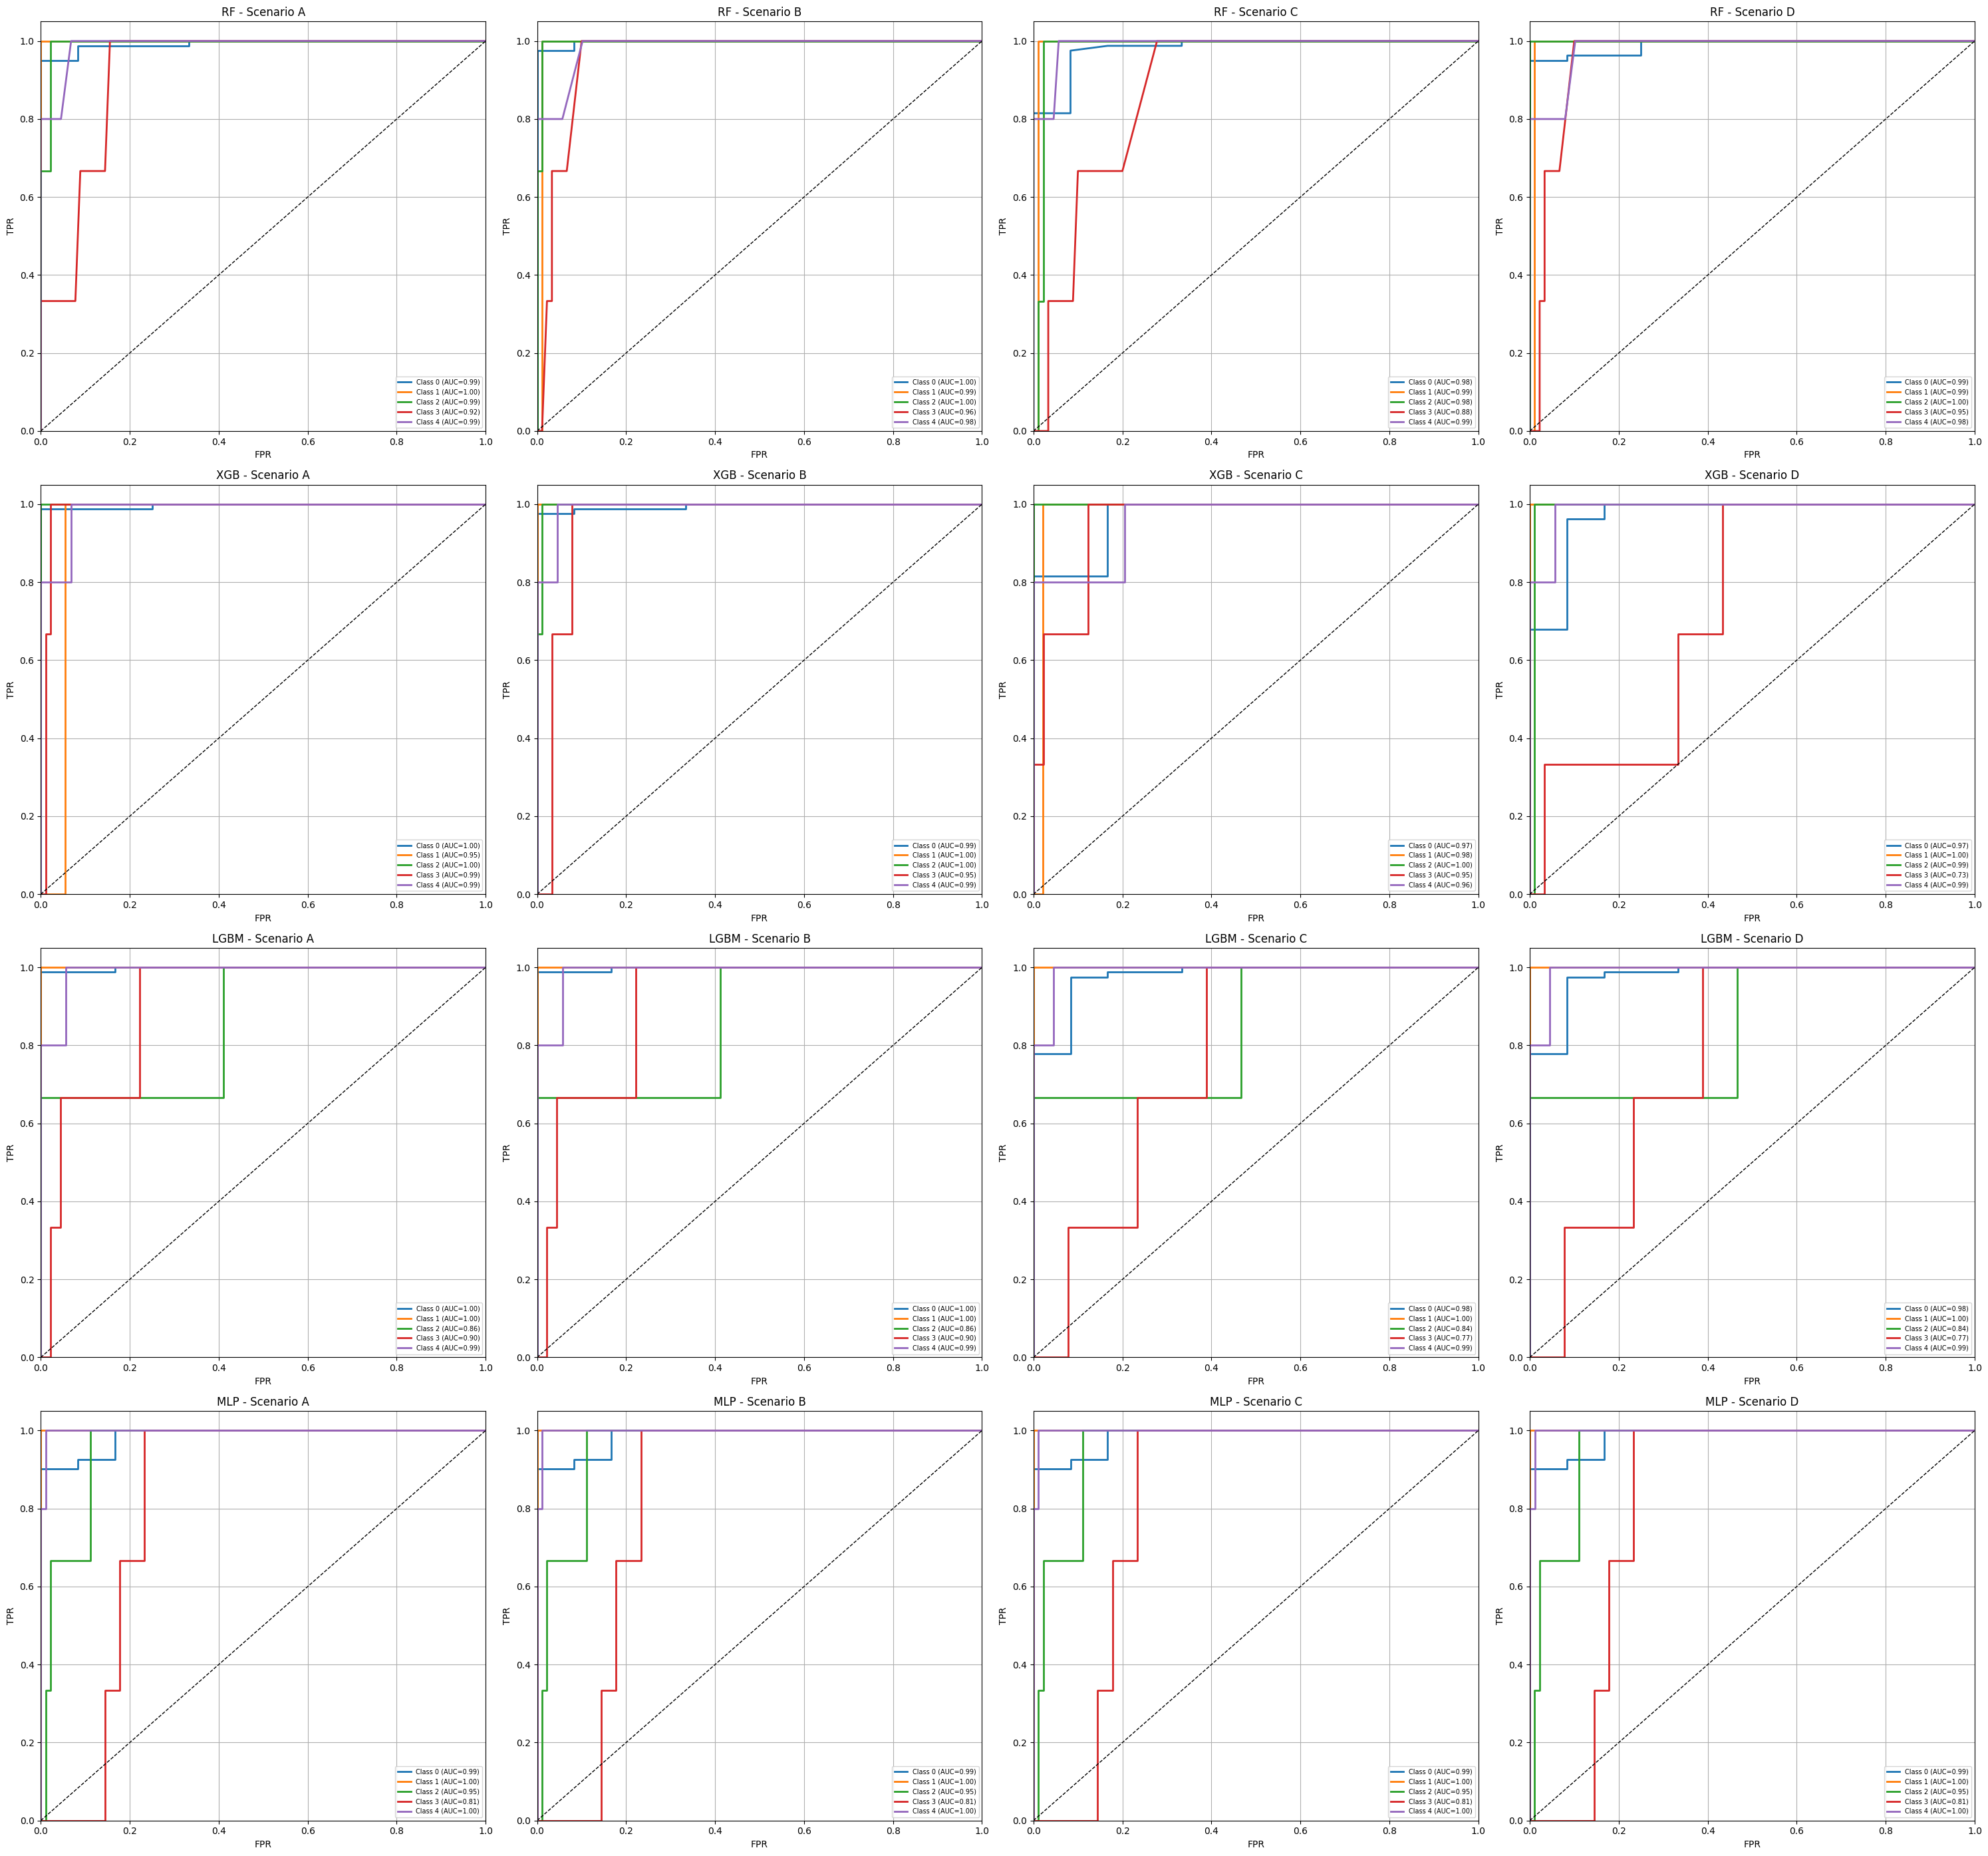

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

scenarios = ['A', 'B', 'C', 'D']
models = {
    'RF': {'A': (rf_a, X_test_rfe_a), 'B': (rf_b, X_test_rfe_b), 'C': (pipeline_c, X_test_scaled), 'D': (pipeline_d, X_test_scaled)},
    'XGB': {'A': (xgb_a, X_test_rfe_a_xgb), 'B': (xgb_b, X_test_rfe_b_xgb), 'C': (pipeline_c_xgb, X_test_scaled), 'D': (pipeline_d_xgb, X_test_scaled)},
    'LGBM': {'A': (lgbm_a, X_test_rfe_a_lgbm), 'B': (lgbm_b, X_test_rfe_b_lgbm), 'C': (pipeline_c_lgbm, X_test_scaled), 'D': (pipeline_d_lgbm, X_test_scaled)},
    'MLP': {'A': (mlp_a, X_test_sel_a_mlp), 'B': (mlp_b, X_test_sel_b_mlp), 'C': (pipeline_c_mlp, X_test_scaled), 'D': (pipeline_d_mlp, X_test_scaled)},
}

classes = np.array([0, 1, 2, 3, 4])
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

fig, axs = plt.subplots(4, 4, figsize=(30, 28))

for row_idx, (model_name, scenario_dict) in enumerate(models.items()):
    for col_idx, scenario in enumerate(scenarios):
        ax = axs[row_idx, col_idx]
        model, X_test_current = scenario_dict[scenario]

        try:
            y_score = model.predict_proba(X_test_current)
        except Exception as e:
            print(f"[ERROR] {model_name} Scenario {scenario}: can't compute probabilities: {e}")
            ax.set_title(f"{model_name} {scenario}: No proba")
            continue

        for idx in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, idx], y_score[:, idx])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, lw=2, label=f'Class {classes[idx]} (AUC={roc_auc:.2f})')

        ax.plot([0, 1], [0, 1], 'k--', lw=1)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title(f"{model_name} - Scenario {scenario}")
        ax.legend(loc="lower right", fontsize=7)
        ax.grid(True)

plt.tight_layout()
plt.show()


Generating F1 line plot for RF - Scenario A


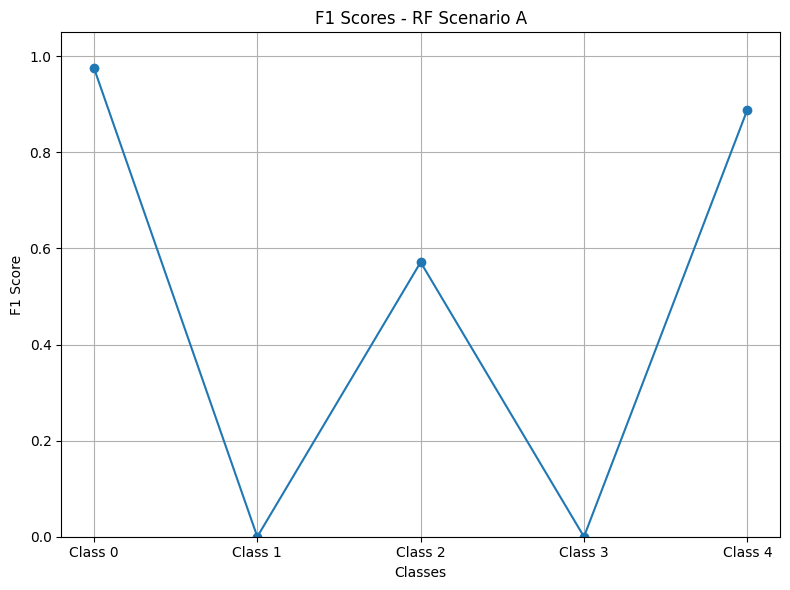

Generating F1 line plot for RF - Scenario B


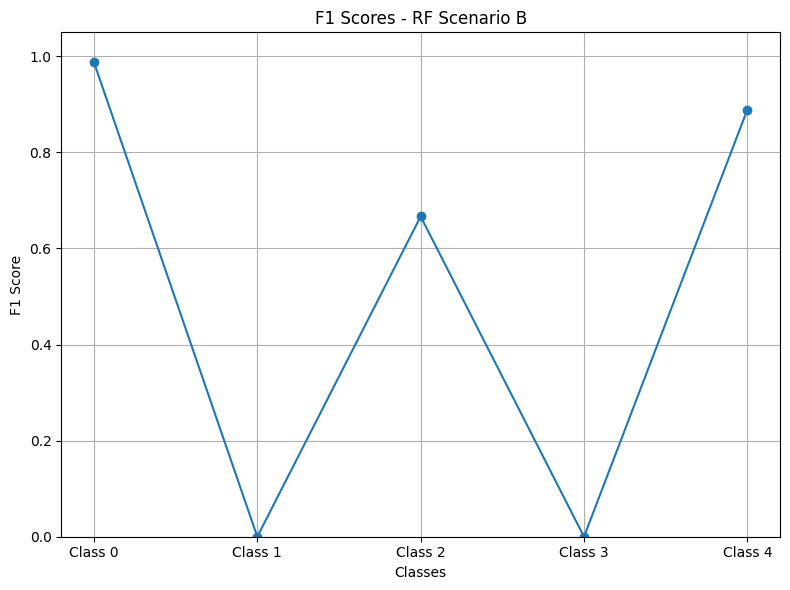

Generating F1 line plot for RF - Scenario C


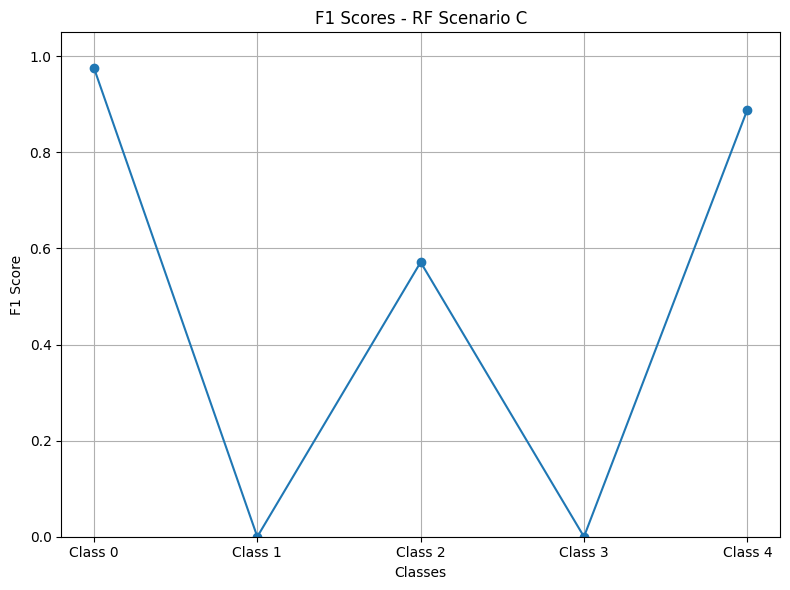

Generating F1 line plot for RF - Scenario D


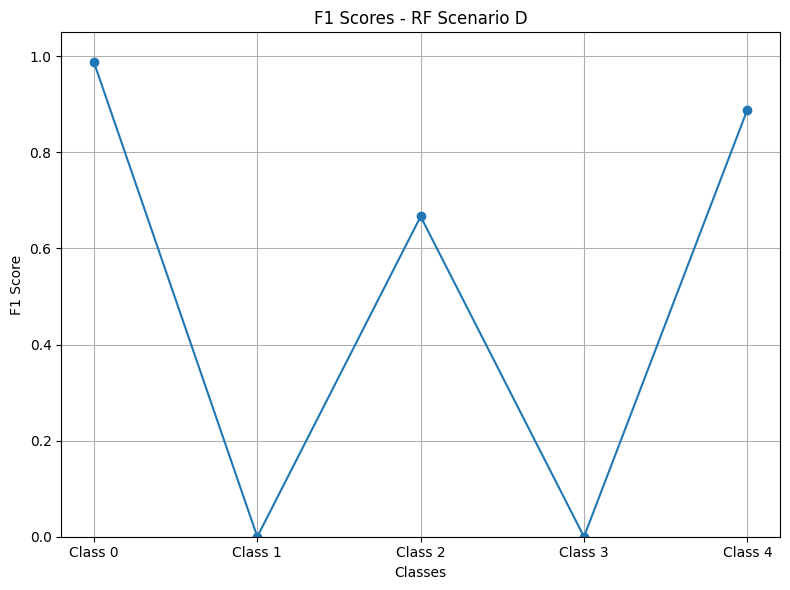

Generating F1 line plot for XGB - Scenario A


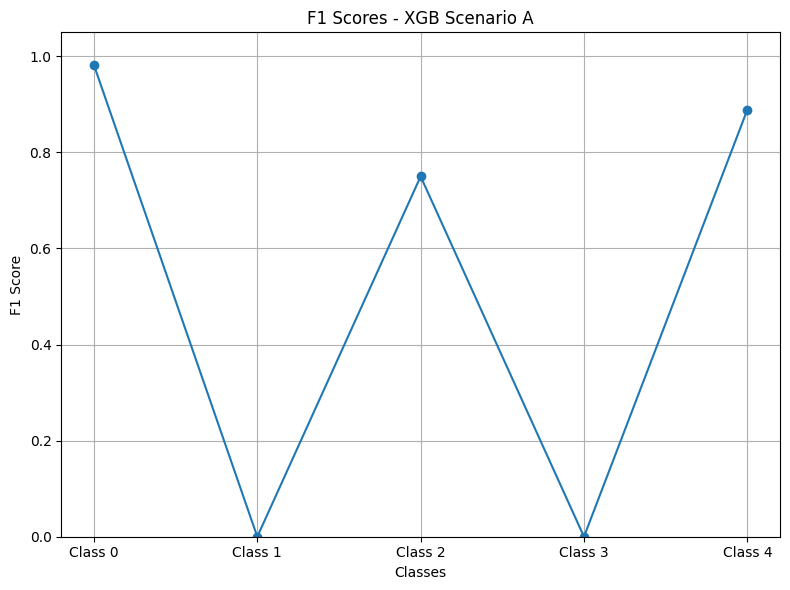

Generating F1 line plot for XGB - Scenario B


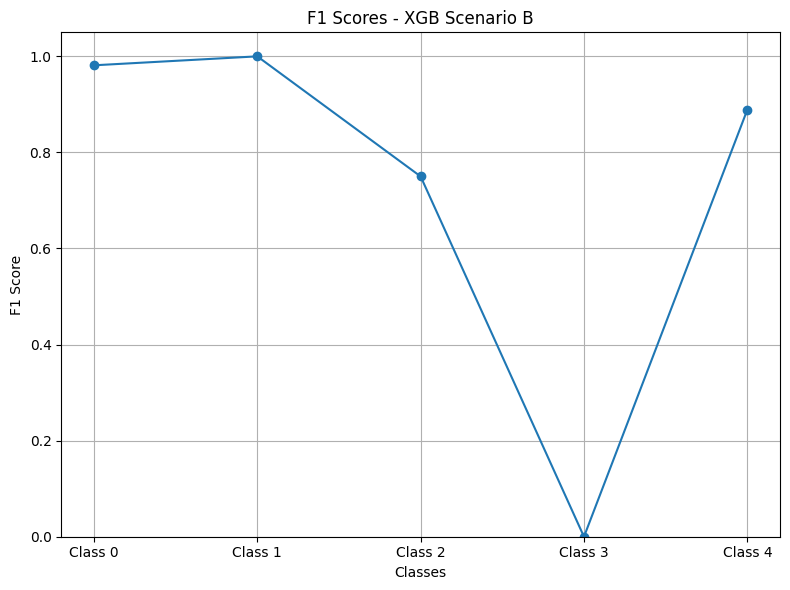

Generating F1 line plot for XGB - Scenario C


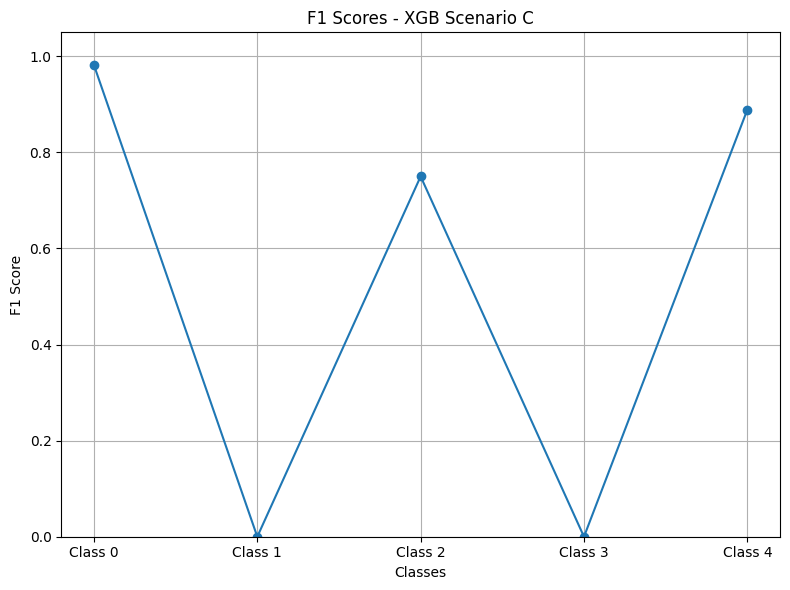

Generating F1 line plot for XGB - Scenario D


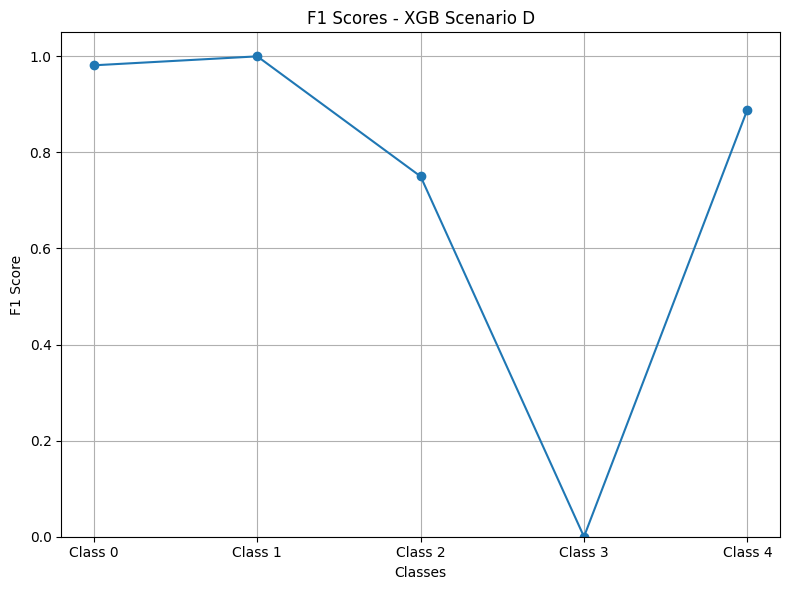

Generating F1 line plot for LGBM - Scenario A


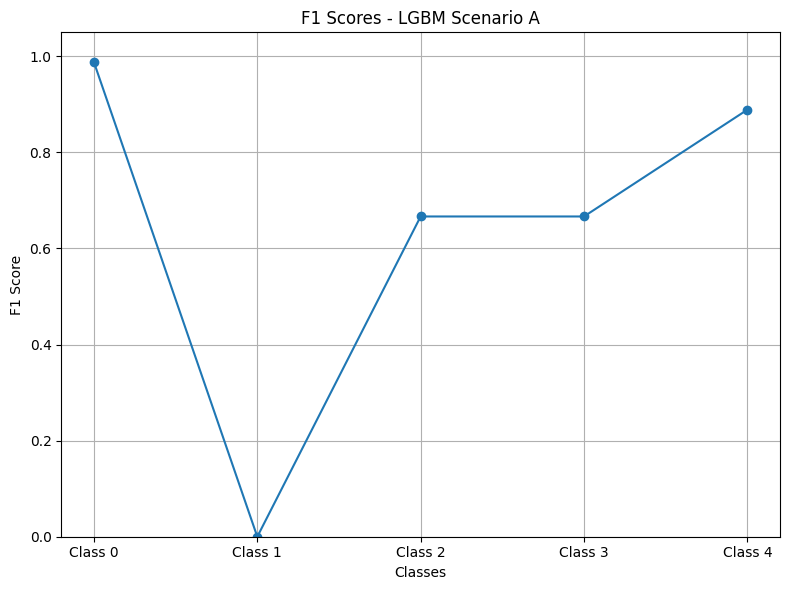

Generating F1 line plot for LGBM - Scenario B


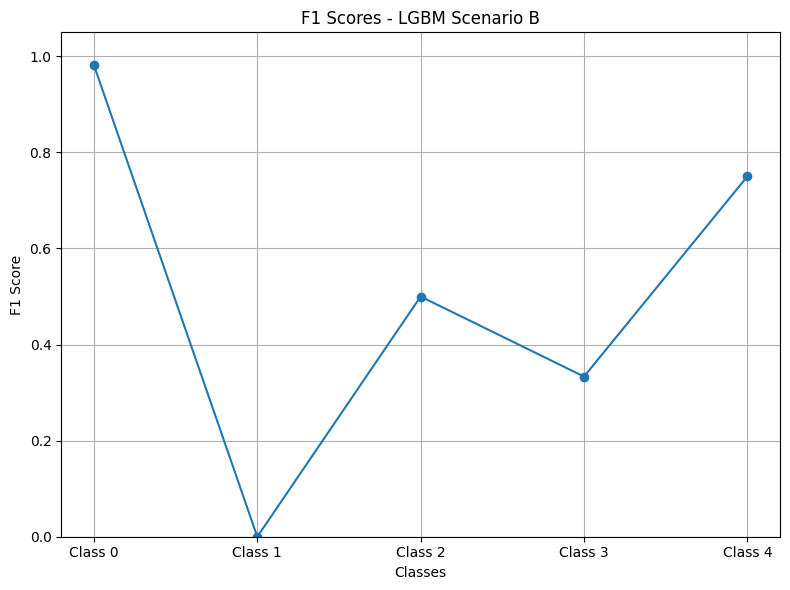

Generating F1 line plot for LGBM - Scenario C


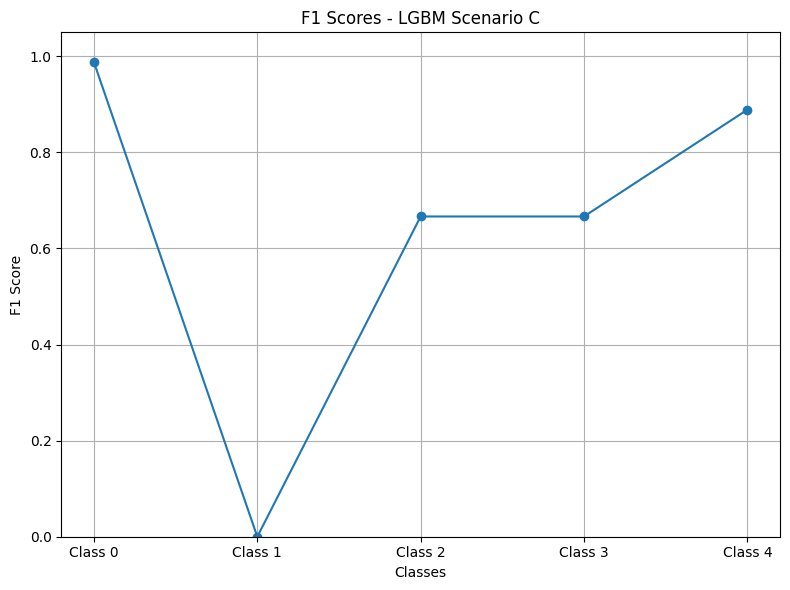

Generating F1 line plot for LGBM - Scenario D


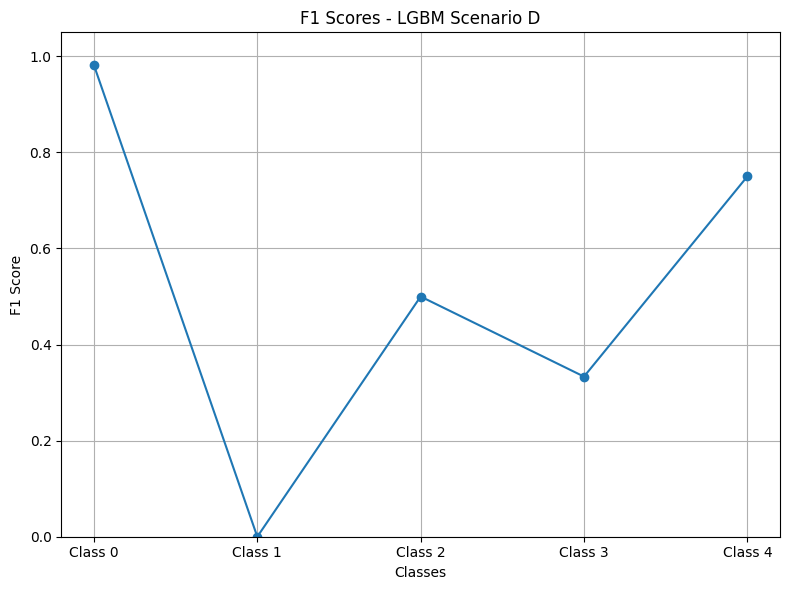

Generating F1 line plot for MLP - Scenario A


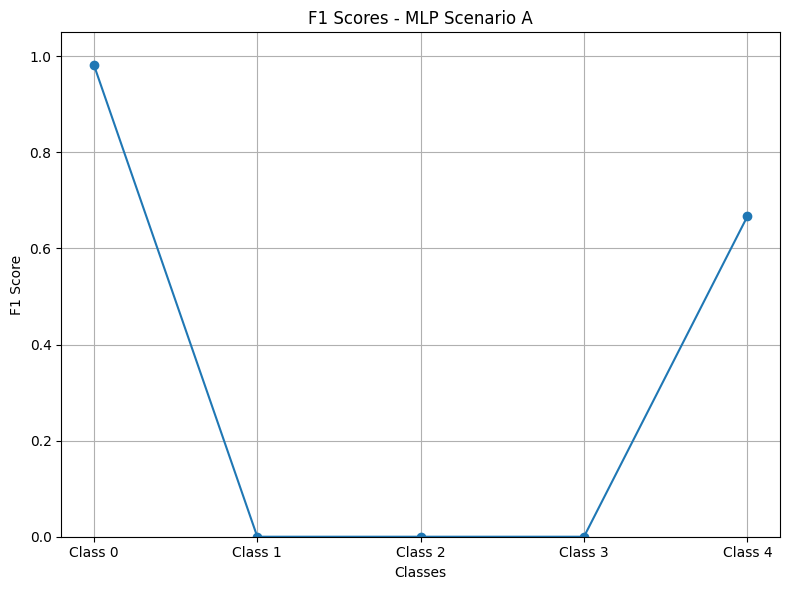

Generating F1 line plot for MLP - Scenario B


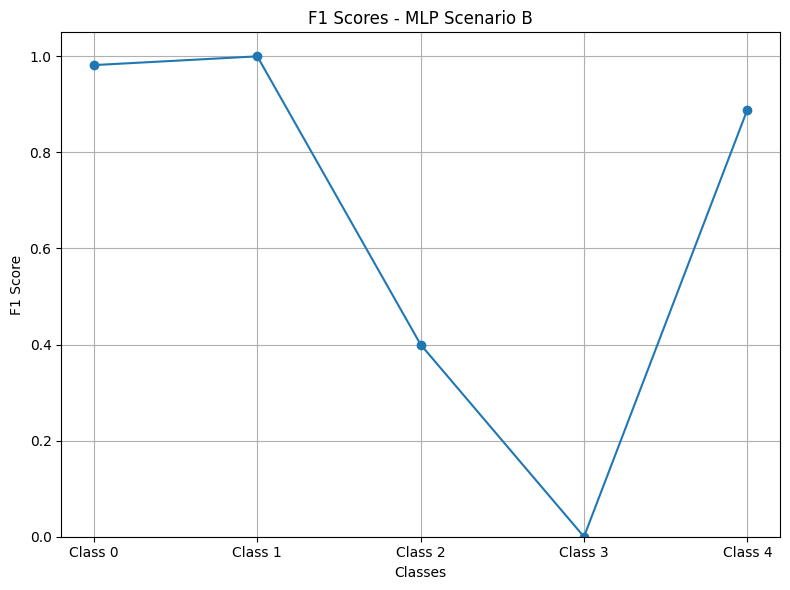

Generating F1 line plot for MLP - Scenario C


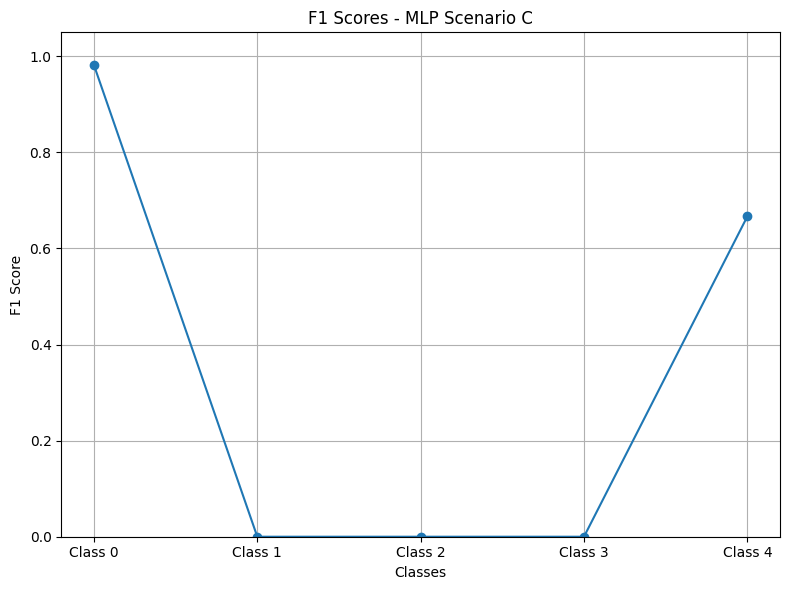

Generating F1 line plot for MLP - Scenario D


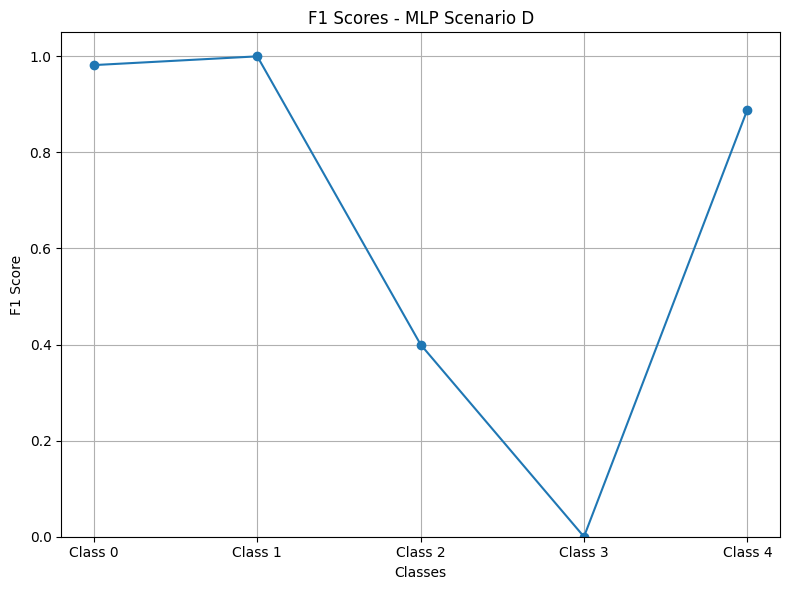

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

# Define models, scenarios, and your y_preds (these must exist in your script)
scenarios = ['A', 'B', 'C', 'D']
models = {
    'RF': {'A': y_test_pred_a, 'B': y_test_pred_b, 'C': y_test_pred_c, 'D': y_test_pred_d},
    'XGB': {'A': y_test_pred_a_xgb, 'B': y_test_pred_b_xgb, 'C': y_test_pred_c_xgb, 'D': y_test_pred_d_xgb},
    'LGBM': {'A': y_test_pred_a_lgbm, 'B': y_test_pred_b_lgbm, 'C': y_test_pred_c_lgbm, 'D': y_test_pred_d_lgbm},
    'MLP': {'A': y_test_pred_a_mlp, 'B': y_test_pred_b_mlp, 'C': y_test_pred_c_mlp, 'D': y_test_pred_d_mlp},
}

classes = [0, 1, 2, 3, 4]

for model_name, preds in models.items():
    for scenario, y_pred in preds.items():
        print(f"Generating F1 line plot for {model_name} - Scenario {scenario}")

        # Calculate F1 scores per class
        report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

        # Collect class F1s
        f1_per_class = []
        for cls in map(str, classes):
            f1 = report.get(cls, {}).get('f1-score', 0)
            f1_per_class.append(f1)

        # Make DataFrame for easy plotting
        df = pd.DataFrame({
            'Class': [f'Class {cls}' for cls in classes],
            'F1': f1_per_class
        })

        # Plot
        plt.figure(figsize=(8, 6))
        plt.plot(df['Class'], df['F1'], marker='o')
        plt.ylim(0, 1.05)
        plt.title(f"F1 Scores - {model_name} Scenario {scenario}")
        plt.xlabel("Classes")
        plt.ylabel("F1 Score")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


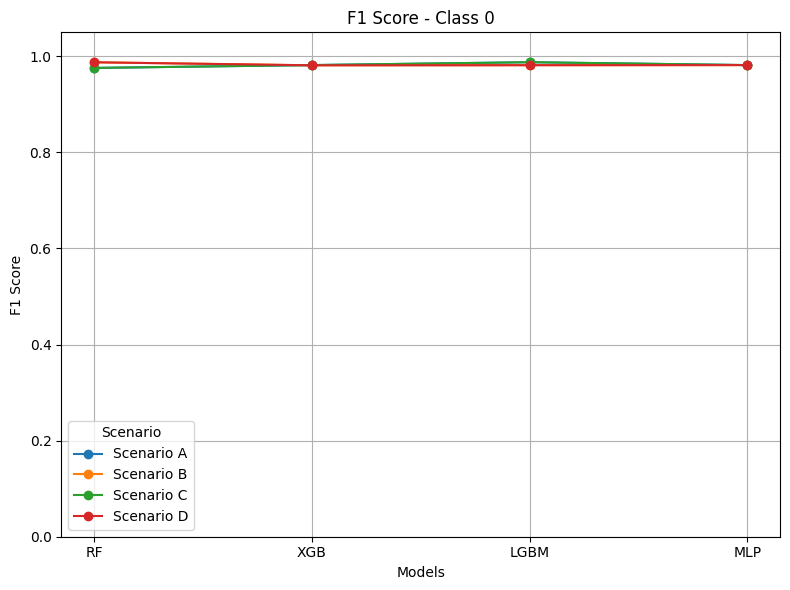

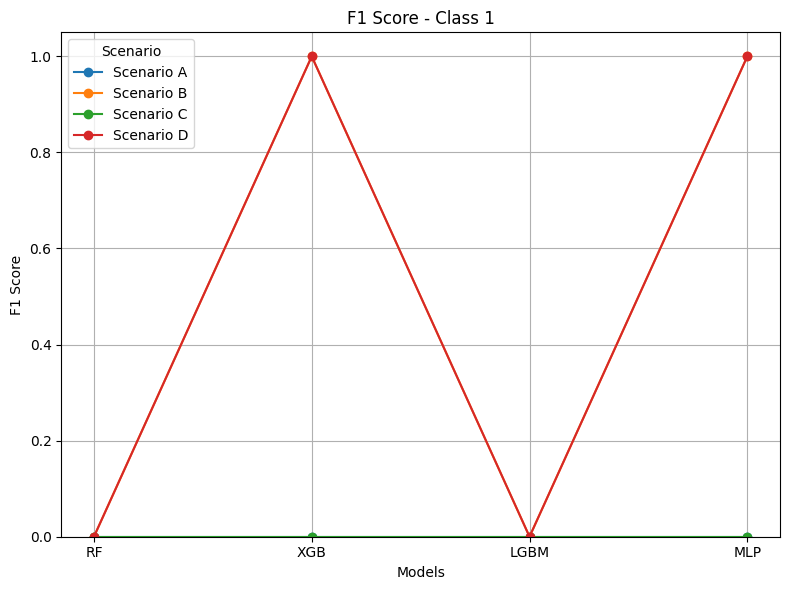

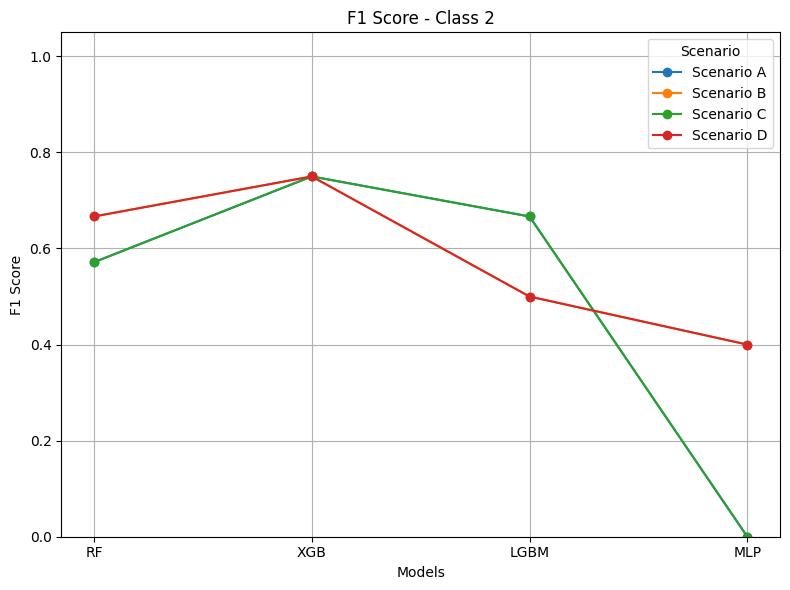

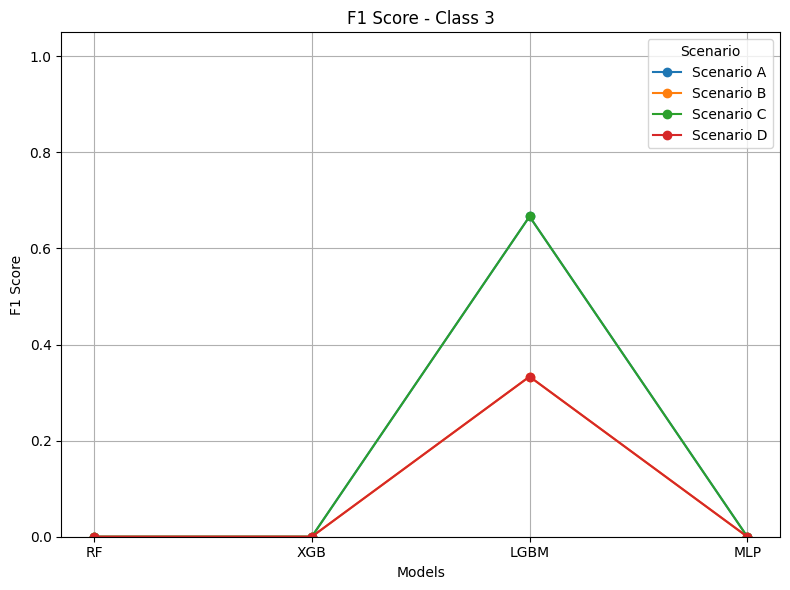

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

# Define scenarios and models + your predictions
scenarios = ['A', 'B', 'C', 'D']
model_order = ['RF', 'XGB', 'LGBM', 'MLP']

# These should match your predictions from earlier code
preds = {
    'RF': {'A': y_test_pred_a, 'B': y_test_pred_b, 'C': y_test_pred_c, 'D': y_test_pred_d},
    'XGB': {'A': y_test_pred_a_xgb, 'B': y_test_pred_b_xgb, 'C': y_test_pred_c_xgb, 'D': y_test_pred_d_xgb},
    'LGBM': {'A': y_test_pred_a_lgbm, 'B': y_test_pred_b_lgbm, 'C': y_test_pred_c_lgbm, 'D': y_test_pred_d_lgbm},
    'MLP': {'A': y_test_pred_a_mlp, 'B': y_test_pred_b_mlp, 'C': y_test_pred_c_mlp, 'D': y_test_pred_d_mlp},
}

classes = [0, 1, 2, 3]  # you asked for 4 plots → classes 0-3

# Collect F1 scores: {class_idx: {scenario: [f1_RF, f1_XGB, f1_LGBM, f1_MLP]}}
f1_data = {cls: {scn: [] for scn in scenarios} for cls in classes}

for cls in classes:
    for scenario in scenarios:
        for model in model_order:
            y_pred = preds[model][scenario]
            report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
            f1 = report.get(str(cls), {}).get('f1-score', 0)
            f1_data[cls][scenario].append(f1)

# Plot one chart per class
for cls in classes:
    plt.figure(figsize=(8, 6))
    for scenario in scenarios:
        plt.plot(model_order, f1_data[cls][scenario], marker='o', label=f"Scenario {scenario}")
    plt.title(f"F1 Score - Class {cls}")
    plt.ylim(0, 1.05)
    plt.xlabel("Models")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.legend(title="Scenario")
    plt.tight_layout()
    plt.show()


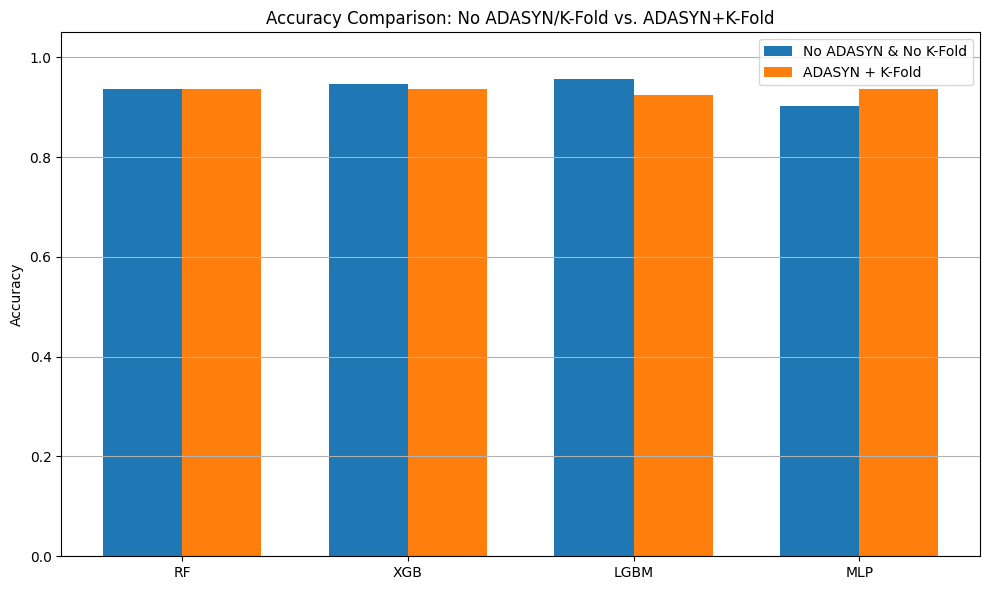

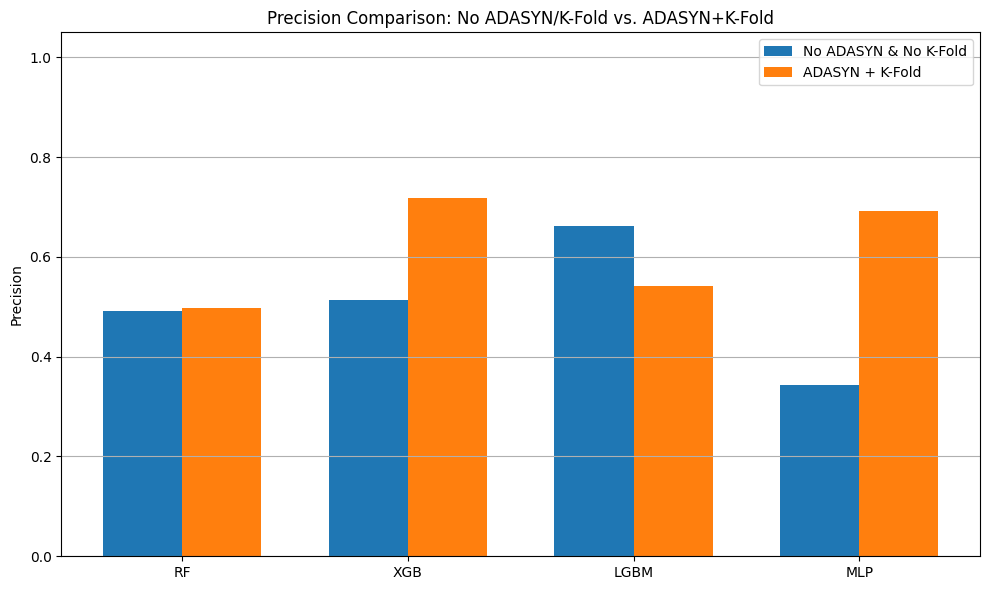

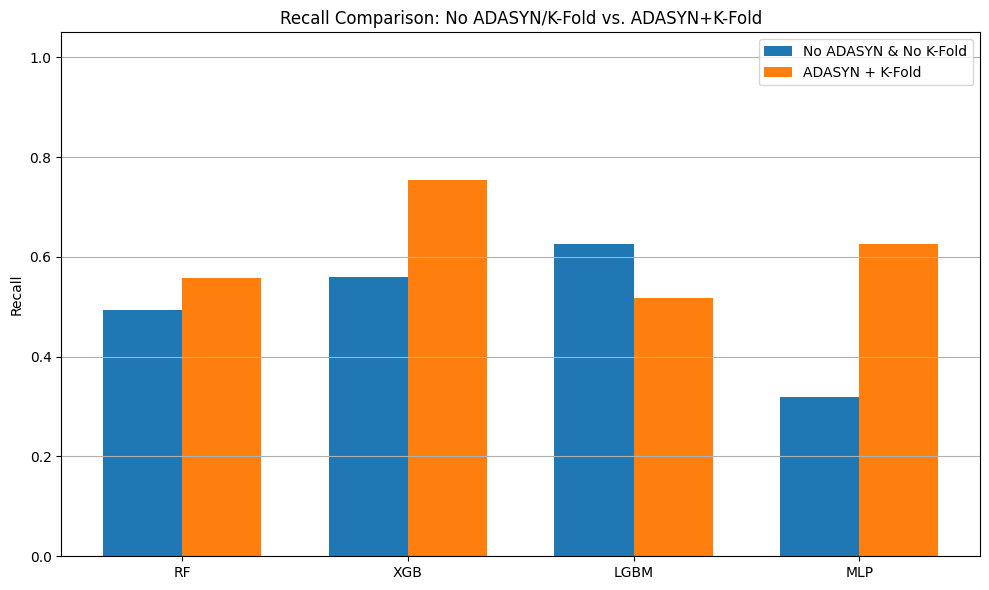

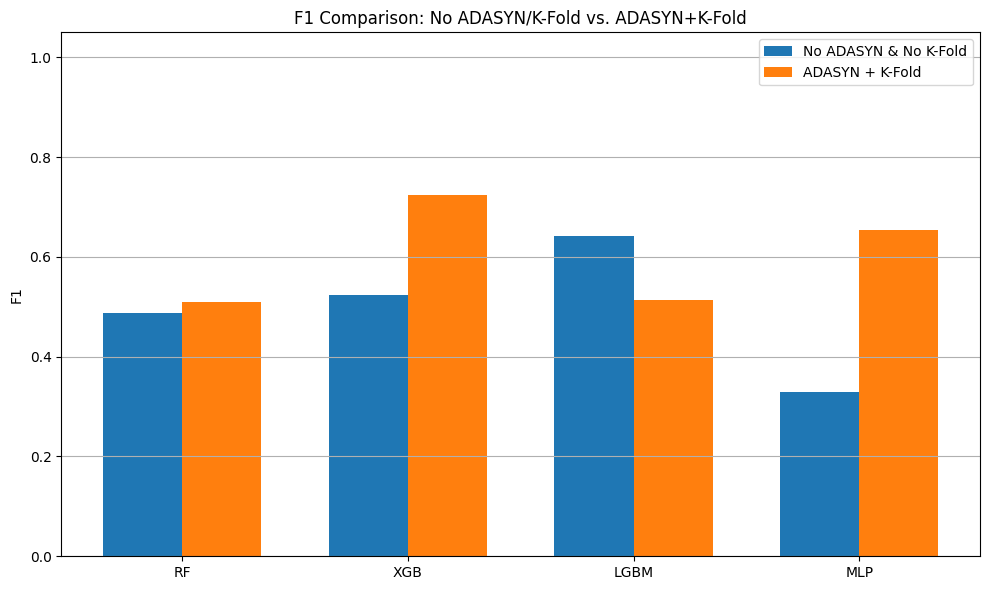

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = ['RF', 'XGB', 'LGBM', 'MLP']

# Predictions for Group 1: No ADASYN & No K-Fold
group1_preds = {
    'RF': y_test_pred_a,
    'XGB': y_test_pred_a_xgb,
    'LGBM': y_test_pred_a_lgbm,
    'MLP': y_test_pred_a_mlp
}

# Predictions for Group 2: ADASYN + K-Fold
group2_preds = {
    'RF': y_test_pred_d,
    'XGB': y_test_pred_d_xgb,
    'LGBM': y_test_pred_d_lgbm,
    'MLP': y_test_pred_d_mlp
}

# Initialize metrics dict
metrics = {'Accuracy': {}, 'Precision': {}, 'Recall': {}, 'F1': {}}

# Compute metrics for Group 1
for metric in metrics.keys():
    metrics[metric]['Group1'] = []
    for model in models:
        y_pred = group1_preds[model]
        if metric == 'Accuracy':
            score = accuracy_score(y_test, y_pred)
        elif metric == 'Precision':
            score = precision_score(y_test, y_pred, average='macro', zero_division=0)
        elif metric == 'Recall':
            score = recall_score(y_test, y_pred, average='macro', zero_division=0)
        elif metric == 'F1':
            score = f1_score(y_test, y_pred, average='macro', zero_division=0)
        metrics[metric]['Group1'].append(score)

# Compute metrics for Group 2
for metric in metrics.keys():
    metrics[metric]['Group2'] = []
    for model in models:
        y_pred = group2_preds[model]
        if metric == 'Accuracy':
            score = accuracy_score(y_test, y_pred)
        elif metric == 'Precision':
            score = precision_score(y_test, y_pred, average='macro', zero_division=0)
        elif metric == 'Recall':
            score = recall_score(y_test, y_pred, average='macro', zero_division=0)
        elif metric == 'F1':
            score = f1_score(y_test, y_pred, average='macro', zero_division=0)
        metrics[metric]['Group2'].append(score)

# Plot each metric
for metric, data in metrics.items():
    fig, ax = plt.subplots(figsize=(10, 6))

    x = range(len(models))
    width = 0.35  # width of bars

    ax.bar([i - width/2 for i in x], data['Group1'], width, label='No ADASYN & No K-Fold')
    ax.bar([i + width/2 for i in x], data['Group2'], width, label='ADASYN + K-Fold')

    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison: No ADASYN/K-Fold vs. ADASYN+K-Fold')
    ax.legend()
    ax.grid(True, axis='y')

    plt.tight_layout()
    plt.show()


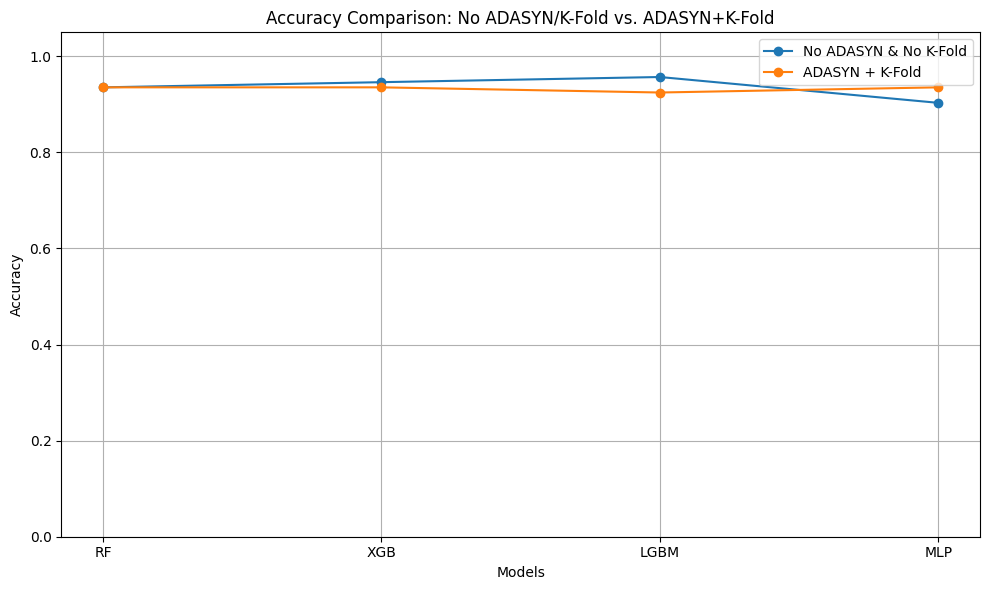

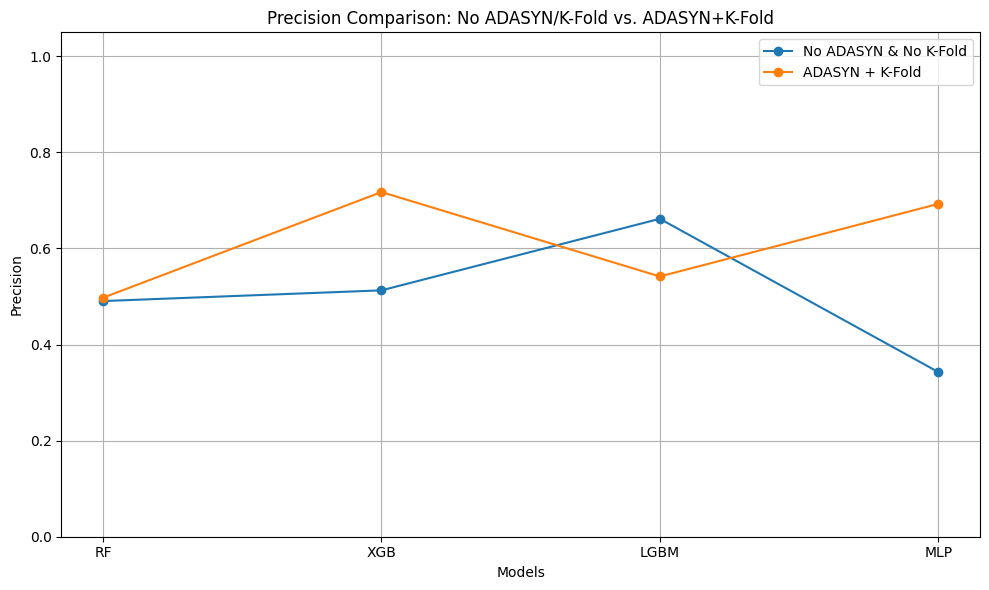

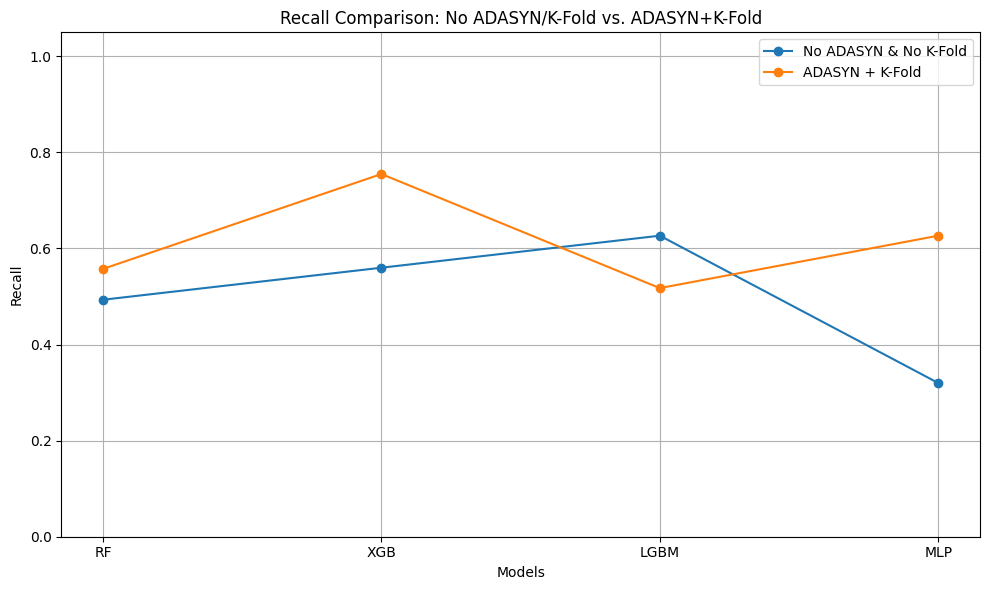

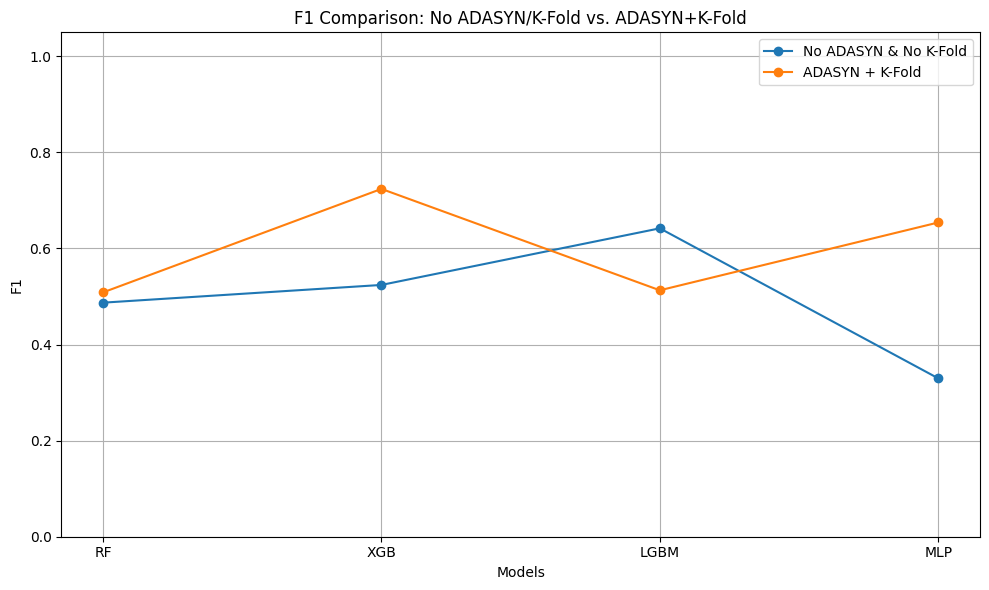

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = ['RF', 'XGB', 'LGBM', 'MLP']

# Group 1: No ADASYN & No K-Fold
group1_preds = {
    'RF': y_test_pred_a,
    'XGB': y_test_pred_a_xgb,
    'LGBM': y_test_pred_a_lgbm,
    'MLP': y_test_pred_a_mlp
}

# Group 2: ADASYN + K-Fold
group2_preds = {
    'RF': y_test_pred_d,
    'XGB': y_test_pred_d_xgb,
    'LGBM': y_test_pred_d_lgbm,
    'MLP': y_test_pred_d_mlp
}

metrics = {'Accuracy': {}, 'Precision': {}, 'Recall': {}, 'F1': {}}

# Compute metrics for Group 1
for metric in metrics.keys():
    metrics[metric]['Group1'] = []
    for model in models:
        y_pred = group1_preds[model]
        if metric == 'Accuracy':
            score = accuracy_score(y_test, y_pred)
        elif metric == 'Precision':
            score = precision_score(y_test, y_pred, average='macro', zero_division=0)
        elif metric == 'Recall':
            score = recall_score(y_test, y_pred, average='macro', zero_division=0)
        elif metric == 'F1':
            score = f1_score(y_test, y_pred, average='macro', zero_division=0)
        metrics[metric]['Group1'].append(score)

# Compute metrics for Group 2
for metric in metrics.keys():
    metrics[metric]['Group2'] = []
    for model in models:
        y_pred = group2_preds[model]
        if metric == 'Accuracy':
            score = accuracy_score(y_test, y_pred)
        elif metric == 'Precision':
            score = precision_score(y_test, y_pred, average='macro', zero_division=0)
        elif metric == 'Recall':
            score = recall_score(y_test, y_pred, average='macro', zero_division=0)
        elif metric == 'F1':
            score = f1_score(y_test, y_pred, average='macro', zero_division=0)
        metrics[metric]['Group2'].append(score)

# Plot each metric as line graph
for metric, data in metrics.items():
    plt.figure(figsize=(10, 6))
    plt.plot(models, data['Group1'], marker='o', label='No ADASYN & No K-Fold')
    plt.plot(models, data['Group2'], marker='o', label='ADASYN + K-Fold')
    plt.ylim(0, 1.05)
    plt.xlabel("Models")
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison: No ADASYN/K-Fold vs. ADASYN+K-Fold')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
